# Работа с временными рядами в R

Основные пакеты для работы с временными рядами и прогнозированием --- `forecast` и `tseries`. При установке пакета `forecast` может возникнуть ошибка при установке зависимого пакета `curl`. Ошибку можно исправив, выполнив

`sudo apt-get -y install libcurl4-gnutls-dev libxml2-dev libssl-dev`

In [1]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)

options(repr.plot.width = 15, repr.plot.height = 6)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




## 1. Обработка временного ряда

**Задача: Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.**

Загрузим данные и посмотрим на начало и конец таблицы

In [2]:
data <- read.csv("./monthly-australian-wine-sales-th.csv", 
                 sep = ",", stringsAsFactors = FALSE)
head(data, 3)
tail(data, 3)

Month,Value
<chr>,<int>
1980-01,464
1980-02,675
1980-03,703


,Month,Value
,<chr>,<int>
186,1995-06,3310
187,1995-07,3923
188,Monthly Australian wine sales: thousands of litres. By wine makers in bottles <= 1 litre.,NA


В конце попара лишняя строка. Удалим ее, а также зададим имена

In [3]:
data <- head(data, -1)

names(data)[1] <- "Date"
names(data)[2] <- "Value"

xname <- "Потребление вина за месяц (тыс. л.)"

head(data)

Date,Value
<chr>,<int>
1980-01,464
1980-02,675
1980-03,703
1980-04,887
1980-05,1139
1980-06,1077


Мы видим, что типы данных определились как строковый и целочисленный соответственно. С каждой колонкой сделаем преобразования:
* Колонку `Value` переведем в вещественный тип с помощью функции `as.numeric`
* Колонку `Date` сначала распарсим на год и месяц с помощью функции `as.yearmon`, а затем приведем к типу "дата" с помощью функции `as.Date`.

In [4]:
data$Value <- as.numeric(data$Value)
data$Date <- as.Date(as.yearmon(data$Date, format = "%Y-%m"))

head(data)

Date,Value
<date>,<dbl>
1980-01-01,464
1980-02-01,675
1980-03-01,703
1980-04-01,887
1980-05-01,1139
1980-06-01,1077


Работа с временными рядами в R происходит с помощью объекта "временной ряд", который можно задать с помощью функции 

`ts(data = NA, start = 1, end = numeric(), frequency = 1,
   deltat = 1, ts.eps = getOption("ts.eps"), class = , names = )`
   
или

`as.ts(x, ...)`

Аргументы:
* `data` --- вектор или матрица значений временных рядов. Данные будут принудительно преобразованы в числовую матрицу с помощью `data.matrix`;
* `start` --- время первого наблюдения. Либо одно число, либо вектор из двух целых чисел, которые задают естественную единицу времени и номер наблюдений в единицу времени (период);
* `end` --- время последнего наблюдения, указанное таким же образом, как и `start`;
* `frequency` --- количество наблюдений в единицу времени (период);
* `deltat` --- частота наблюдений в единицу времени, равна 1/период. Из параметров `frequency` и `deltat` должен быть указан только один;
* `ts.eps` --- малое число для сравнения временных рядов. Значения считаются одинаковыми, если их абсолютная разность не превосходит `ts.eps`;
* `class` --- класс для результата. Для одномерных рядов это `ts`, для многомерных --- `mts`, `ts` или `matrix`.

-----

Создадим временной ряд с помощью наших данных. Он имеет период 12 (месяцев). В качестве старта передаем два числа --- год и месяц, распарсенные с помощью функции `format`. Формально, первое число --- начальное время, а второе --- номер значения в эту единицу времени, с которого начинаются наблюдения.

In [5]:
tSeries <- ts(data = data$Value, 
              start = as.numeric(c(format(data$Date[1], "%Y"), 
                                   format(data$Date[1], "%m"))), 
              freq = 12)

tSeries

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1980,464,675,703,887,1139,1077,1318,1260,1120,963,996,960
1981,530,883,894,1045,1199,1287,1565,1577,1076,918,1008,1063
1982,544,635,804,980,1018,1064,1404,1286,1104,999,996,1015
1983,615,722,832,977,1270,1437,1520,1708,1151,934,1159,1209
1984,699,830,996,1124,1458,1270,1753,2258,1208,1241,1265,1828
1985,809,997,1164,1205,1538,1513,1378,2083,1357,1536,1526,1376
1986,779,1005,1193,1522,1539,1546,2116,2326,1596,1356,1553,1613
1987,814,1150,1225,1691,1759,1754,2100,2062,2012,1897,1964,2186
1988,966,1549,1538,1612,2078,2137,2907,2249,1883,1739,1828,1868
1989,1138,1430,1809,1763,2200,2067,2503,2141,2103,1972,2181,2344


График данного временного ряда

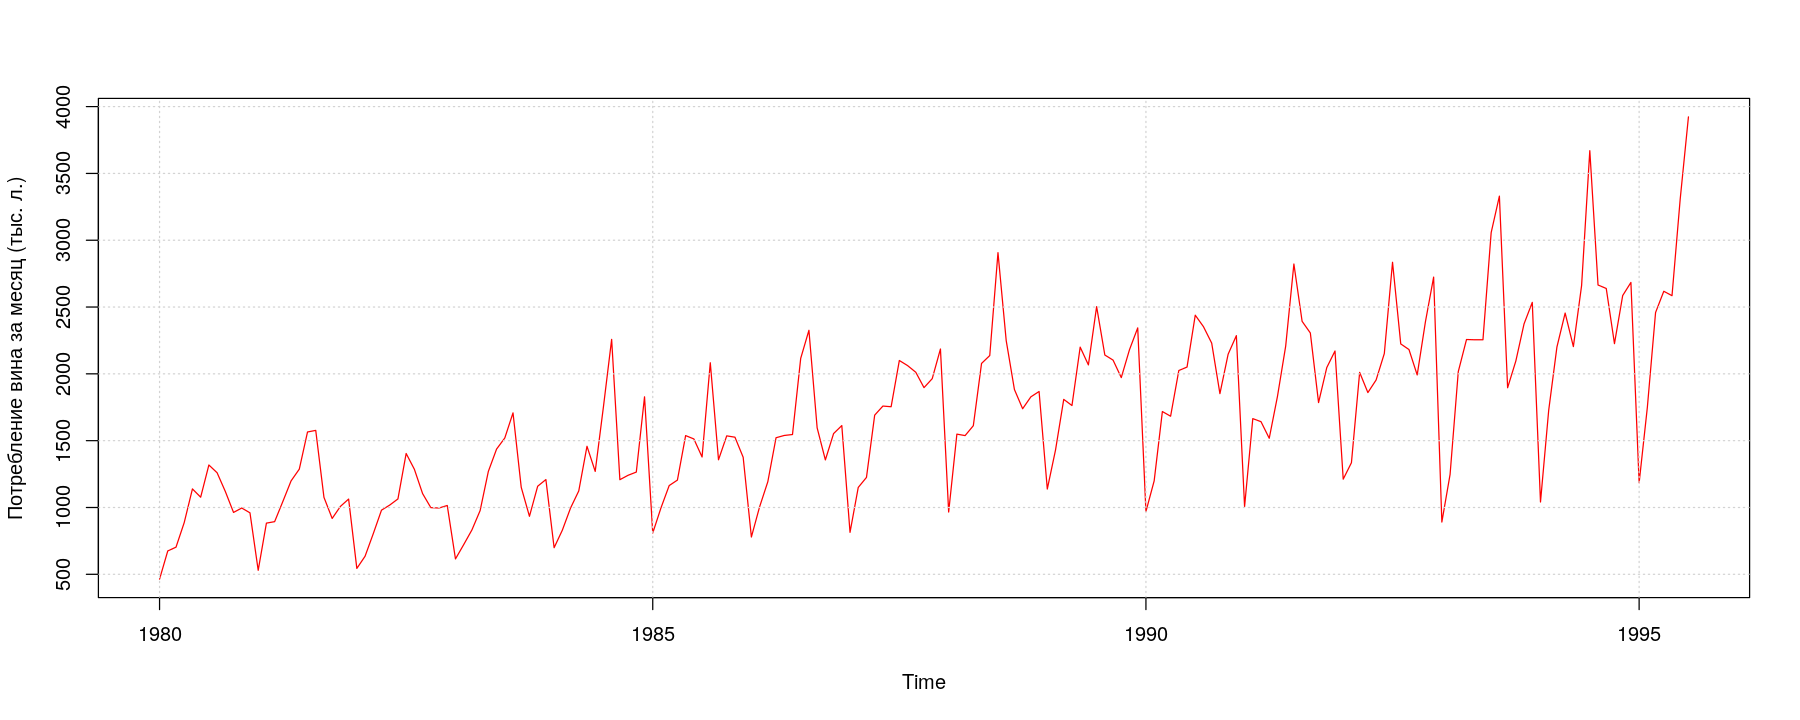

In [6]:
plot(tSeries, type = "l", ylab = xname, col = "red")
grid()

Разбиение на train и test можно сделать с помощью функции `window`, которая выдает кусок временного ряда от момента времени `start` (по умолчанию начало ряда) до `end` (по умолчанию конец ряда). 

Все, что до августа 1992 года отнесем train; все, что после -- в test.

In [7]:
trainSeries <- window(tSeries, end = c(1992, 8))
testSeries  <- window(tSeries, start = c(1992, 9))
D <- 36

## 2. Простая аналитика

Подумав над природой временного ряда понимаем, что на значениях может сказываться неравномерность дней в месяцах. Количество дней в месяце можно узнать с помощью функции `monthDays`. Ей нужно передать дату, которую мы извлекаем из временного ряда с помощью функции `time` и преобразовывая ее в тип "дата" с помощью функции `as.Date`.

Поделим значения ряда на количество дней в месяце

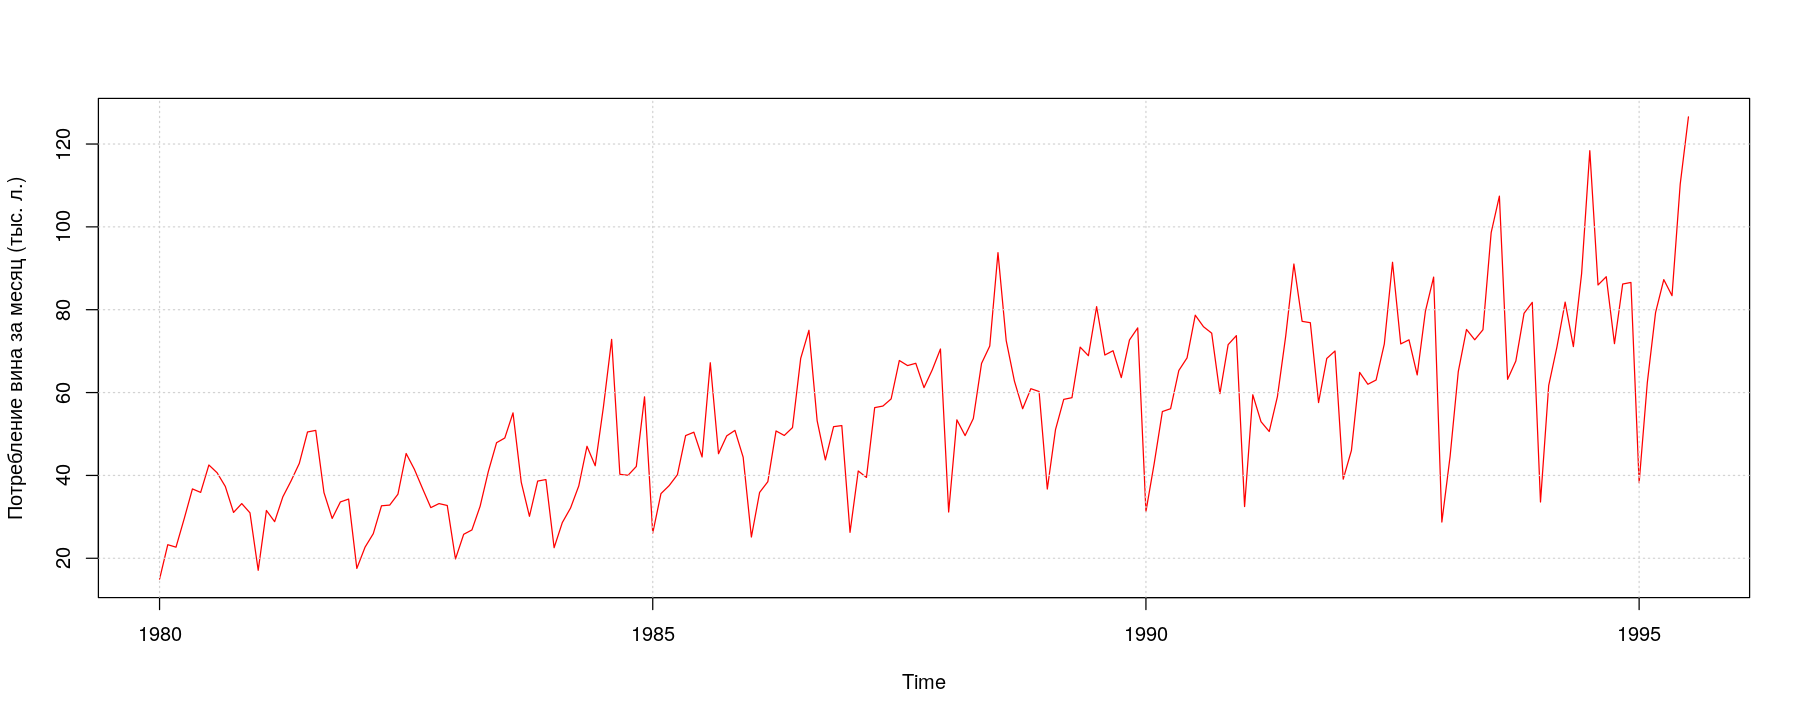

In [8]:
plot(tSeries / monthDays(as.Date(time(tSeries))), 
     type = "l", ylab = xname, col = "red")
grid()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

Сделаем STL-декомпозицию ряда. Функция имеет множество параметров для тонкой настройки декомпозиции. Подробнее можно почитать в документации.

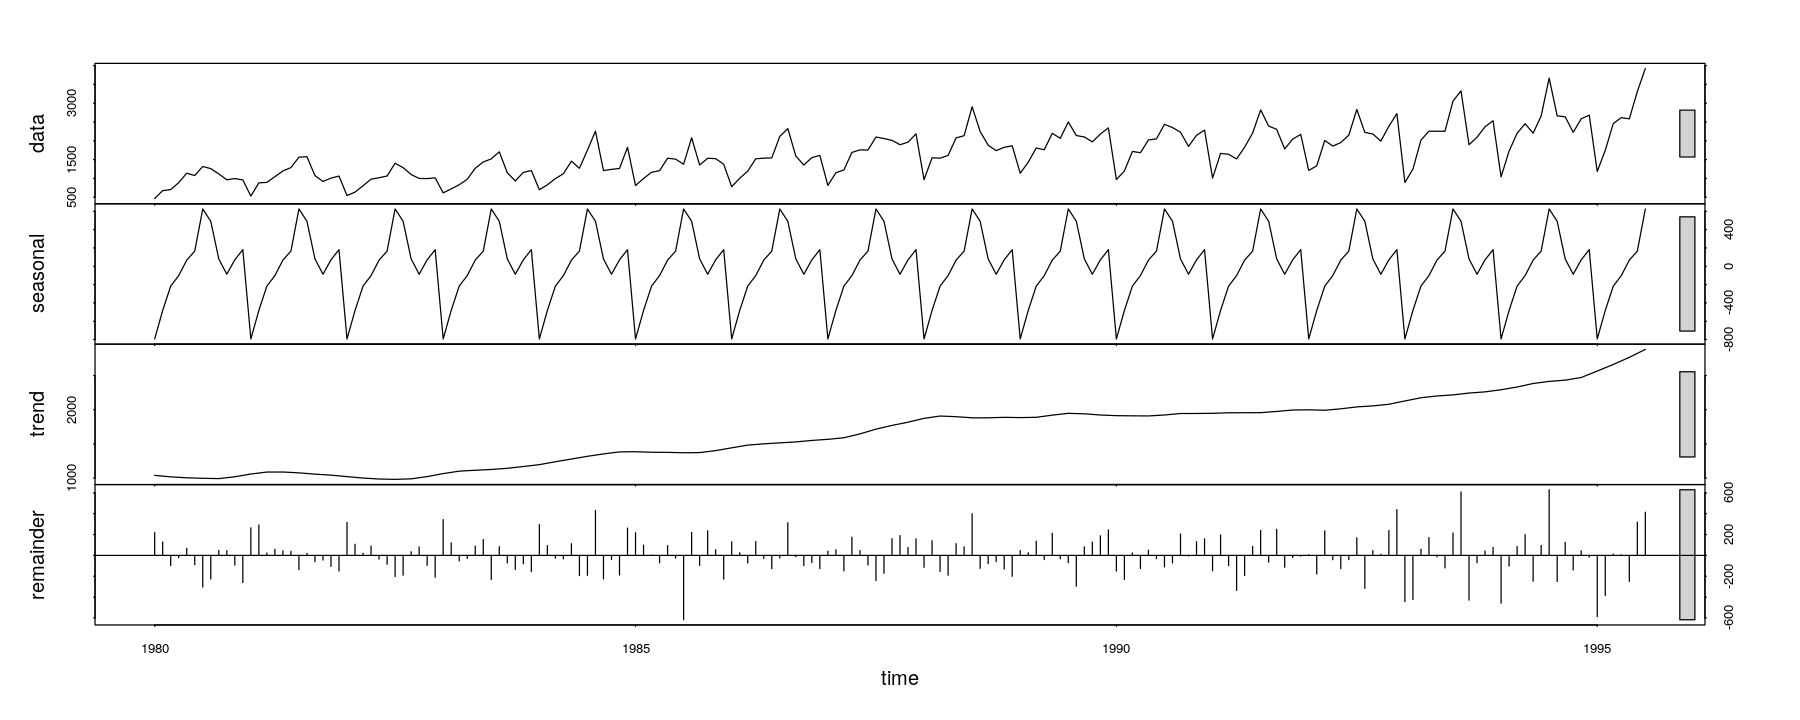

In [9]:
stl.decompose <- stl(tSeries, s.window = "periodic")
plot(stl.decompose)

Можно извлечь сами значения

In [10]:
head(stl.decompose$time.series)

,seasonal,trend,remainder
Jan 1980,-793.36254,1039.508,217.85480
Feb 1980,-482.18279,1028.676,128.50729
Mar 1980,-216.50310,1017.843,-98.34018
Apr 1980,-101.72348,1010.979,-22.25575
May 1980,67.05632,1004.115,67.82849
Jun 1980,165.37573,1000.266,-88.64187


Функция `BoxCox.lambda` автоматически подбирает оптимальное преобразование Бокса-Кокса. Выполним его и посмотрим на результат его применения:

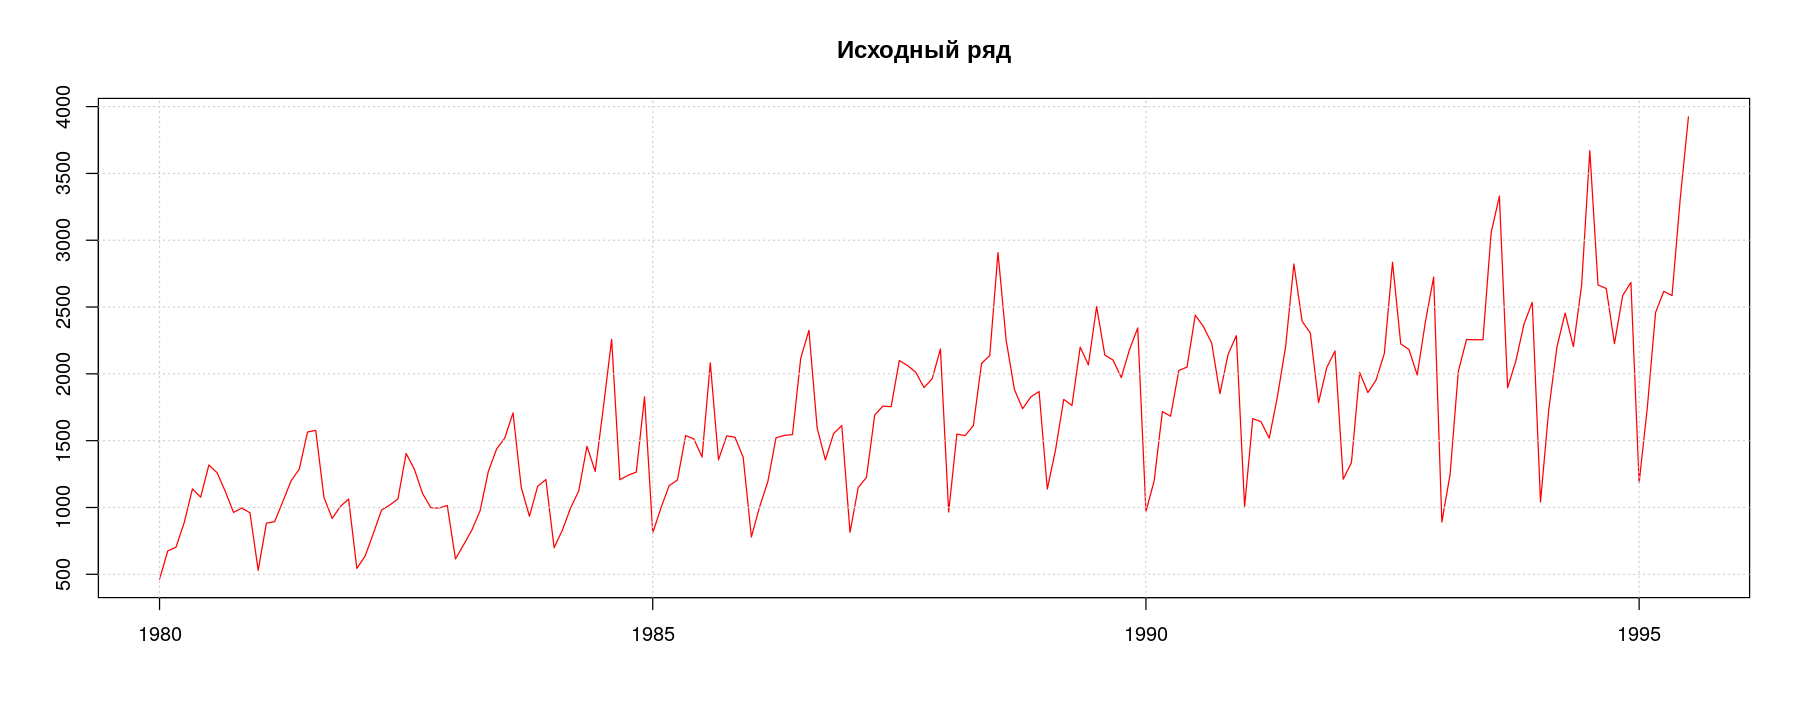

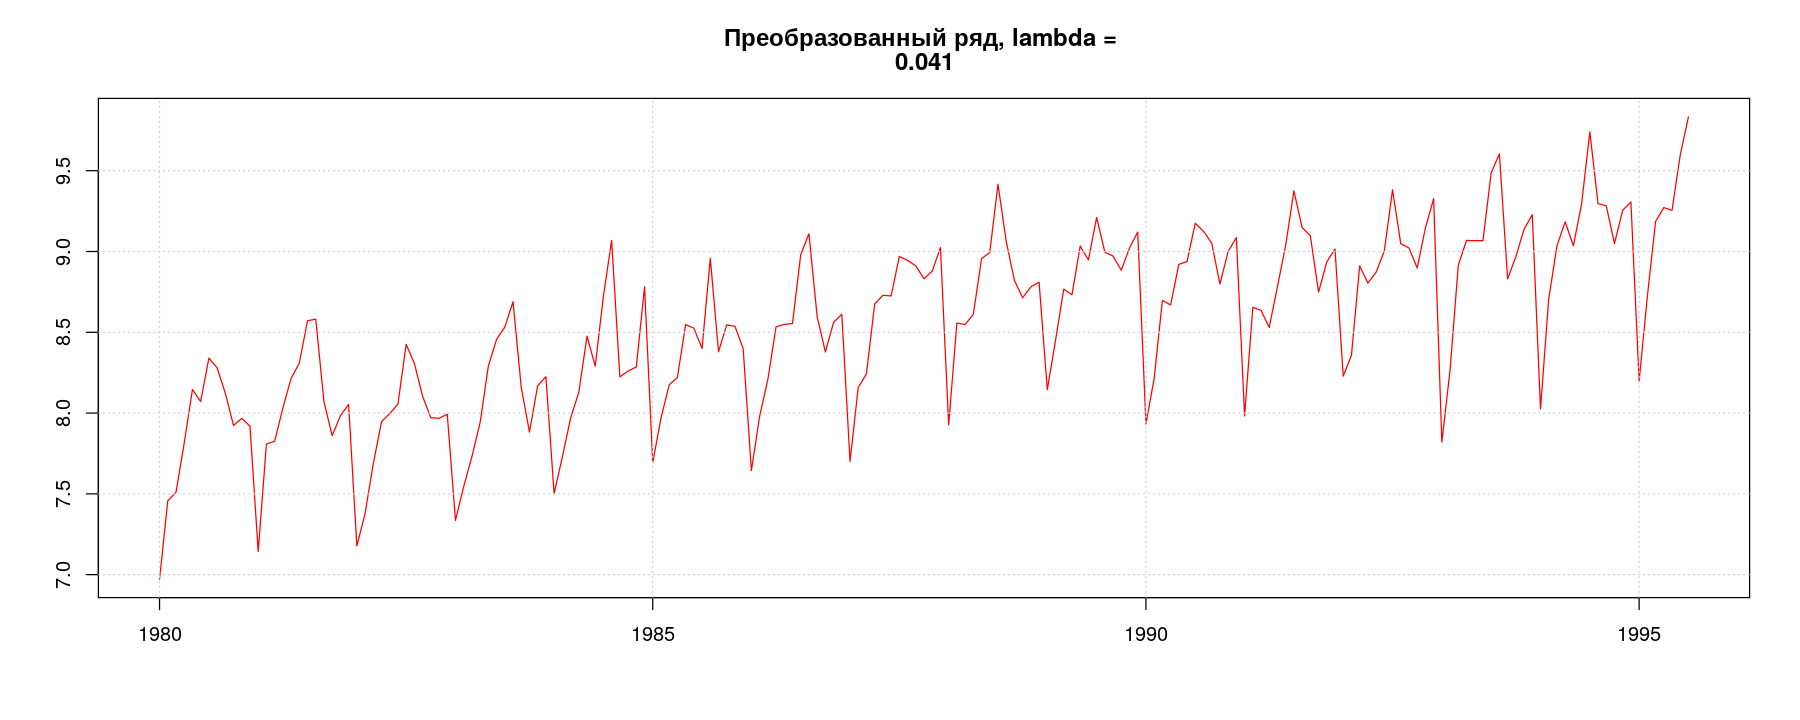

In [11]:
# График исходного ряда
plot(tSeries, xlab = "", ylab="", col = "red")
title(main="Исходный ряд")
grid()

# Преобразование
LambdaOpt <- BoxCox.lambda(tSeries)

# График преобразованного ряда
plot(BoxCox(tSeries, LambdaOpt), xlab="", ylab="", col="red")
title(main=c("Преобразованный ряд, lambda = ", toString(round(LambdaOpt, 3))))
grid()

Ряд не выглядит существенно более стационарным, так что откажемся от преобразования Бокса-Кокса.

## 3. Прогноз ETS (Экспоненциальным сглаживанием)

Аргументы:
* `y` --- числовой вектор или объект класса `ts`;
* `model` --- срока из трех букв, задающая тип модели. Например, тип `ANN` соответствует простому экспоненциальному сглаживанию с аддитивной ошибкой, а тип `MAM` --- сглаживанию с мультипликативной ошибкой и сезонностью и аддитивным трендом (модель Хольта-Уинтерса). По умолчанию `ZZZ` --- автоматический выбор модели. Подробнее:
* * Первая буква: `"A", "M" или "Z"` --- тип ошибки;
* * Вторая буква: `"N","A","M" или "Z"` --- тип тренда;
* * Третья буква: `"N","A","M" или "Z"` --- тип сезонности;
* * `N` -- не используется (для тренда или сезонности);
* * `A` -- аддитивная;
* * `M` -- мультипликативная;
* * `Z` -- выбирается автоматически;
* `damped` --- использовать ли затухающий тренд. Если `NULL`, то будут опробованны оба варианта;
* `alpha`, `beta`, `gamma`, `phi` --- параметры моделей (см. презентацию). Если указано `NULL`, то подбираются автоматически;
* `lower` и `upper` --- Границы на значения параметров;
* `additive.only` --- Если TRUE, то подбираются только аддитивные модели. По умолчанию `FALSE`;
* `lambda` --- Параметр преобразования Бокса-Кокса. Может быть `lambda="auto"`, тогда параметр подбирается с помощью функции `BoxCox.lambda`. Преобразование не используется если указано `NULL`;
* `opt.crit` --- критерий оптимизации: `"mse"` (Mean Square Error), `"amse"` (Average MSE over first nmse forecast horizons), `"sigma"` (Standard deviation of residuals), `"mae"` (Mean of absolute residuals), or `"lik"` (Log-likelihood, the default);
* `ic` --- информационный критерий для выбора модели;
* `restrict` --- рассматривать ли модели с бесконечной дисперсией;
* `allow.multiplicative.trend` --- рассматривать ли модели с мультипликативным трендом;
* `na.action` --- функция, указывающая на то, что делать с пропусками;

Сделаем автоматический выбор модели на наших данных. Подобна модель с мультипликативной ошибкой и сезонностью и аддитивным трендом (модель Хольта-Уинтерса). В выводе указаны также оптимальные значения параметров модели, а также значения $l$, $b$, $s$ в начальный момент времени. Следующие значения $l$, $b$, $s$ пересчитываются через начальные значения, параметры модели и значения ряда по формулам модели.

In [12]:
model.ets <- ets(tSeries)
print(model.ets)

ETS(M,Ad,M) 

Call:
 ets(y = tSeries) 

  Smoothing parameters:
    alpha = 0.1849 
    beta  = 0.0149 
    gamma = 2e-04 
    phi   = 0.9671 

  Initial states:
    l = 931.8299 
    b = 7.7138 
    s = 1.1098 1.028 0.9382 1.0511 1.3287 1.3538
           1.0941 1.0486 0.9522 0.8601 0.7096 0.526

  sigma:  0.113

     AIC     AICc      BIC 
2922.632 2926.703 2980.792 


### Разберем сразу функцию прогнозирования значений, общую для всех моделей.

Аргументы:

* `object` --- модель;
* `h` --- горизонт прогнозирования
* `level` --- уровень доверия предсказательных интервалов
* `fan` --- если `TRUE`, то строит интервалы разных уровней, что подходит для fan plots.
* `robust` --- использовать ли робастные прогнозы.

-----

Рассмотрим модель с мультипликативной сезонностью и мультипликативными ошибками. Прогнозирование осуществляется с помощью функции `forecast`, которой передается обученная модель и горизонт прогнозирования. Функция `accuracy` вычисляет качество модели как на обучающих данных, так и на тестовых.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,27.4637,176.9042,128.9961,0.845731,8.30697,0.6877698,-0.006536106,NA
Test set,426.9203,549.8809,455.5682,15.680692,18.15986,2.4289570,0.209402942,0.7716804


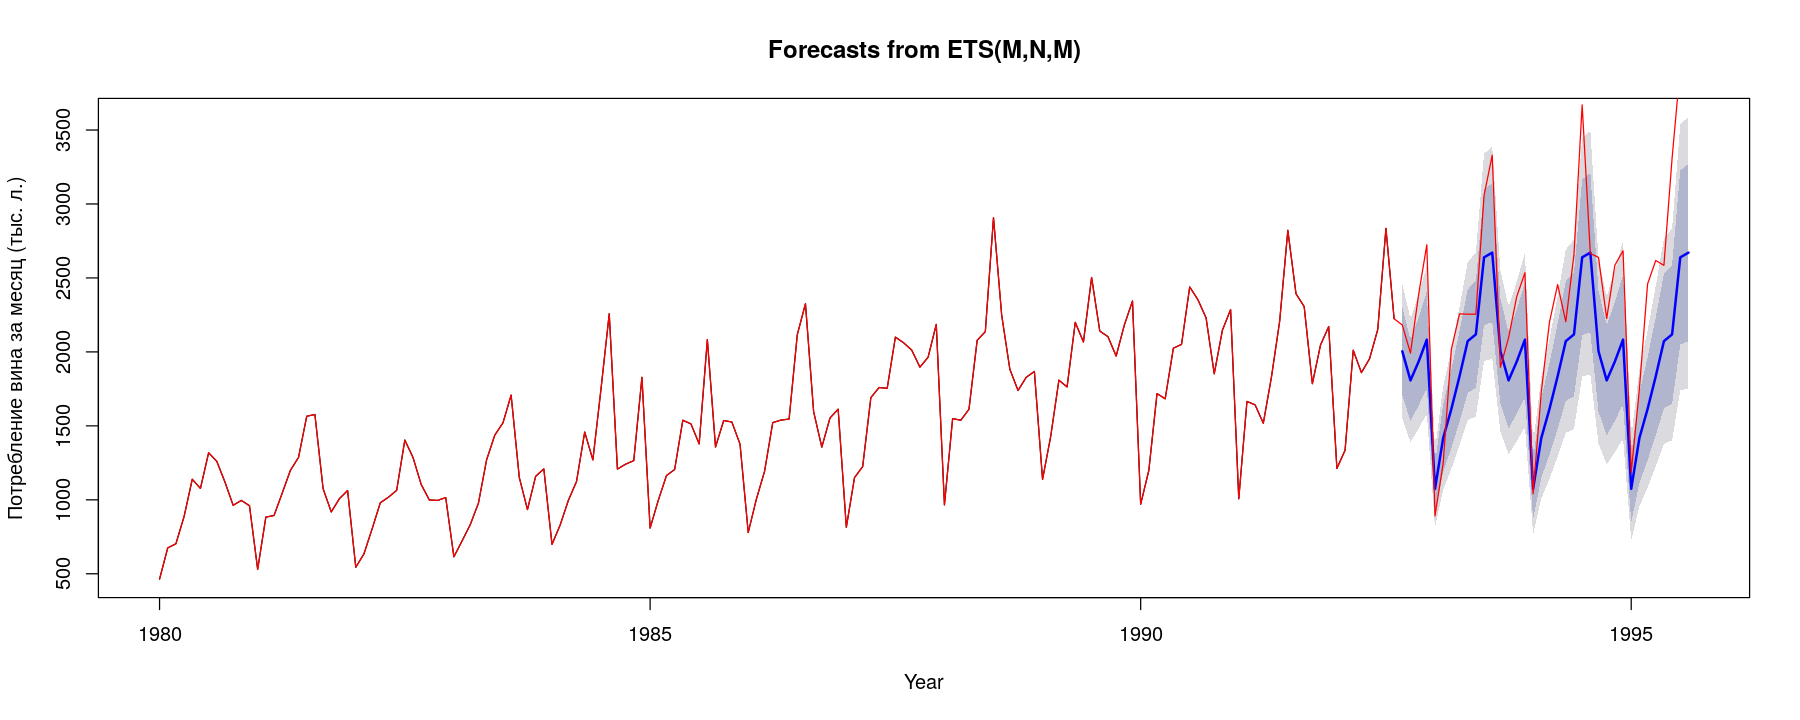

In [13]:
# построение модели
model.ets <- ets(trainSeries, model = "MNM", damped = FALSE)

# Прогнозирование
predicted <- forecast(model.ets, h = D)

# Вычисление качества
accuracy(predicted, testSeries)

# График
plot(predicted, ylab = xname, xlab = "Year")
lines(tSeries, col = "red")

Можно посмотреть на сами прогнозы и границы предсказательных интервалов

In [14]:
head(data.frame(predicted))

,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sep 1992,2003.997,1706.6906,2301.304,1549.3060,2458.689
Oct 1992,1807.319,1534.3251,2080.313,1389.8109,2224.827
Nov 1992,1934.827,1637.4527,2232.201,1480.0323,2389.622
Dec 1992,2083.027,1757.4532,2408.600,1585.1049,2580.949
Jan 1993,1074.403,903.7235,1245.082,813.3713,1335.435
Feb 1993,1417.439,1188.6901,1646.188,1067.5978,1767.280


Остатки модели можно извлечь с помощью функции `residuals`. Построим график остатков, а также коррелограмму (график автокорреляций) и график частичных автокорреляций. Видно, что все лаги незначимы

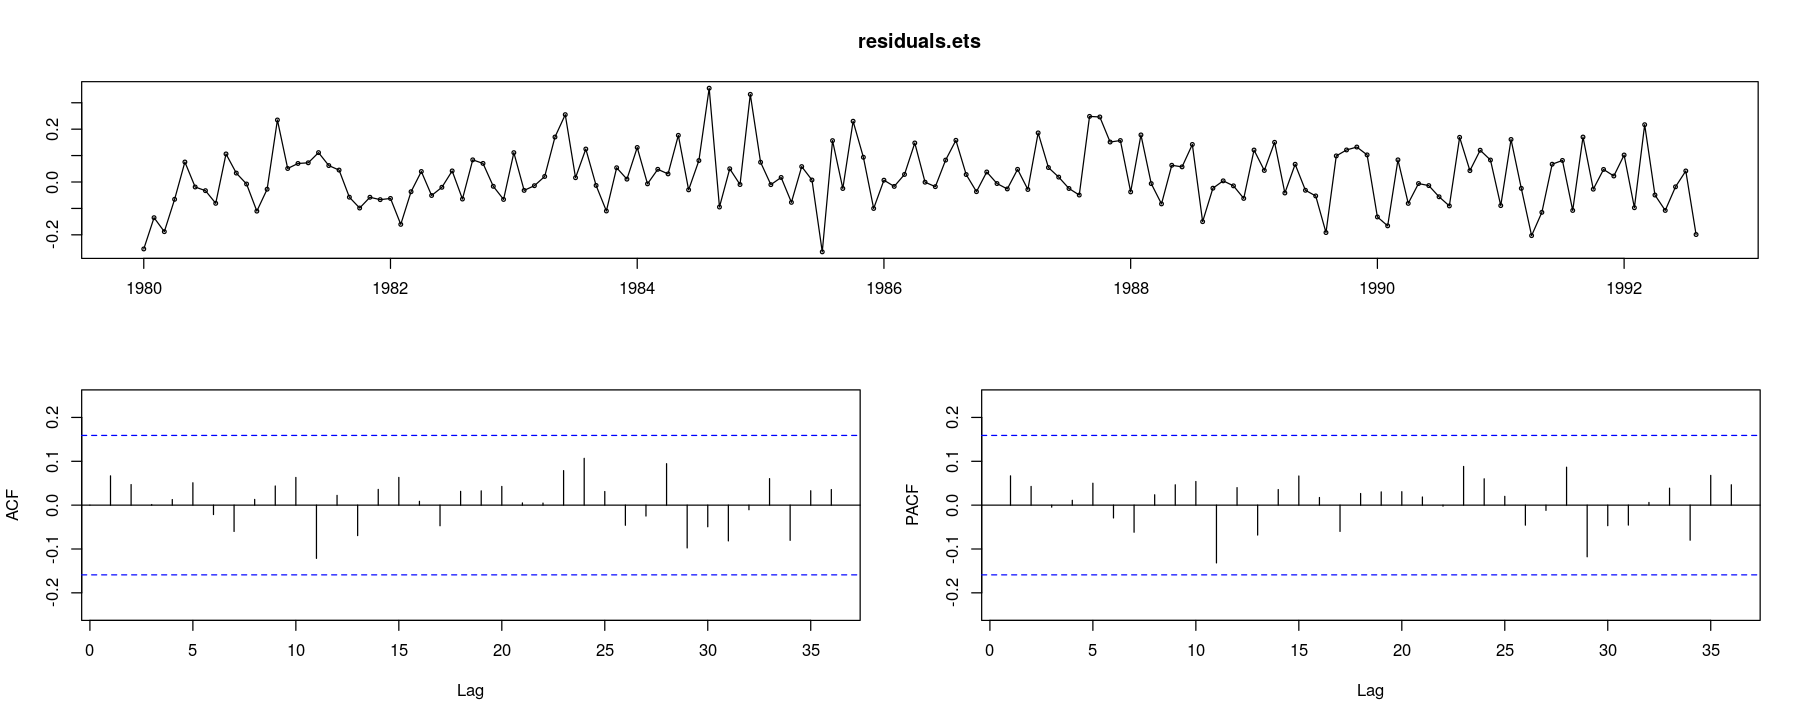

In [15]:
residuals.ets <- residuals(model.ets)

tsdisplay(residuals.ets)

p-value критерия Льюнга-Бокса `Box.test` о наличии значимых лагов автокорреляции:

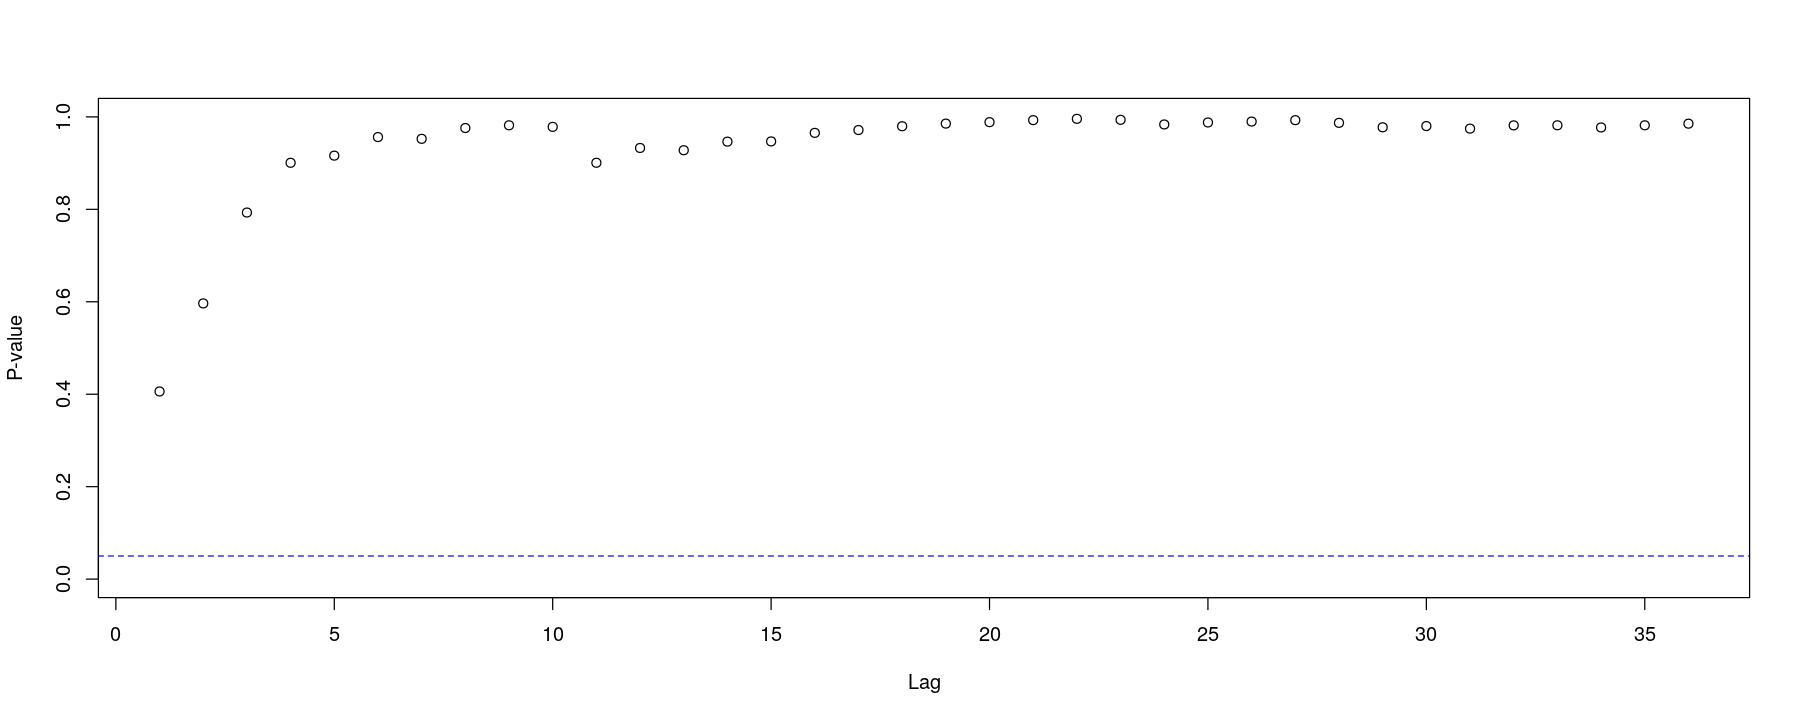

In [16]:
# вычисления pvalue
p <- rep(0, 1, frequency(residuals.ets)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(residuals.ets, lag = i, type = "Ljung-Box")$p.value
}

# график
plot(p, xlab = "Lag", ylab = "P-value", ylim = c(0, 1))
abline(h = 0.05, lty = 2, col = "blue")

Все pvalue выше порога, поэтому все автокорреляции в остатках незначимы. В общем случае необходимо делать поправку на множественное тестирование:

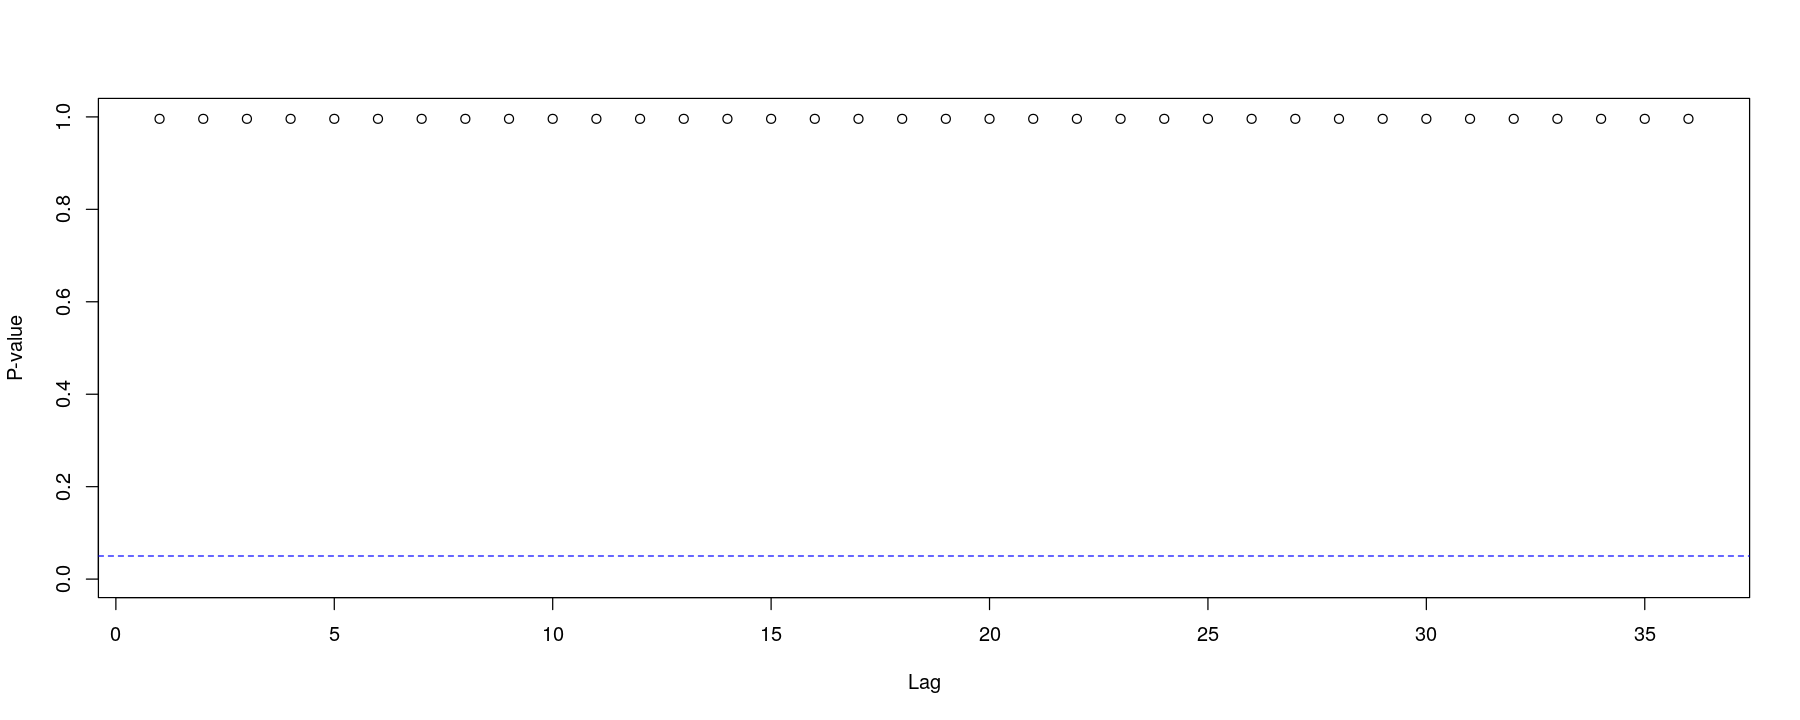

In [17]:
corrected.pvals <- p.adjust(p, method = 'BH')

plot(corrected.pvals, xlab = "Lag", ylab = "P-value", ylim = c(0, 1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot и гистограмма для остатков:

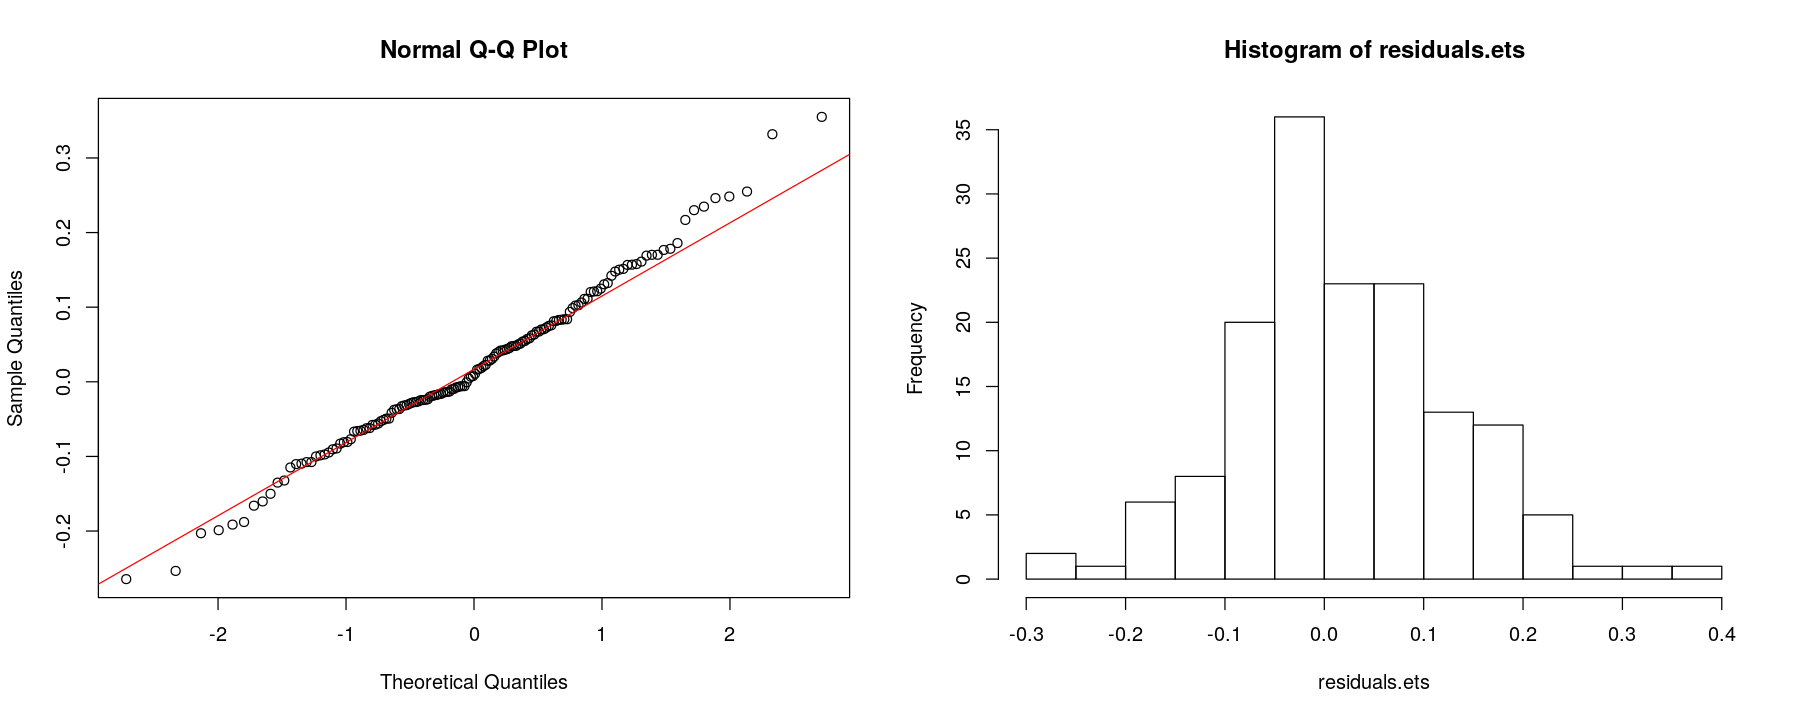

In [18]:
# два графика в строчку
par(mfrow = c(1, 2))
# QQ-plot и линия на нем
qqnorm(residuals.ets)
qqline(residuals.ets, col = "red")
# гистограмма
hist(residuals.ets)

Проверяем гипотезы для остатков:
* Нормальность --- критерий Шапиро-Уилка
* Несмещённость --- критерий Уилкоксона
* Стационарность --- критерий KPSS
* Гомоскедастичность --- критерий Бройша-Пагана 

In [19]:
shapiro.test(residuals.ets)$p.value
wilcox.test(residuals.ets)$p.value
kpss.test(residuals.ets)$p.value
bptest(residuals.ets ~ c(1:length(residuals.ets)))$p.value

[1] 0.4121664

[1] 0.04237341

Warning message in kpss.test(residuals.ets):
“p-value greater than printed p-value”


[1] 0.1

BP 
0.8529943

* Нормальность --- не отвергается
* Несмещённость --- не отвергается
* Стационарность --- не отвергается
* Гомоскедастичность --- не отвергается 

## 4. ARIMA,  ручной подбор модели

Проверим исходный ряд на стационарность

In [20]:
kpss.test(trainSeries)$p.value

Warning message in kpss.test(trainSeries):
“p-value smaller than printed p-value”


[1] 0.01

Исходный ряд нестационарен; сделаем сезонное дифференцирование:

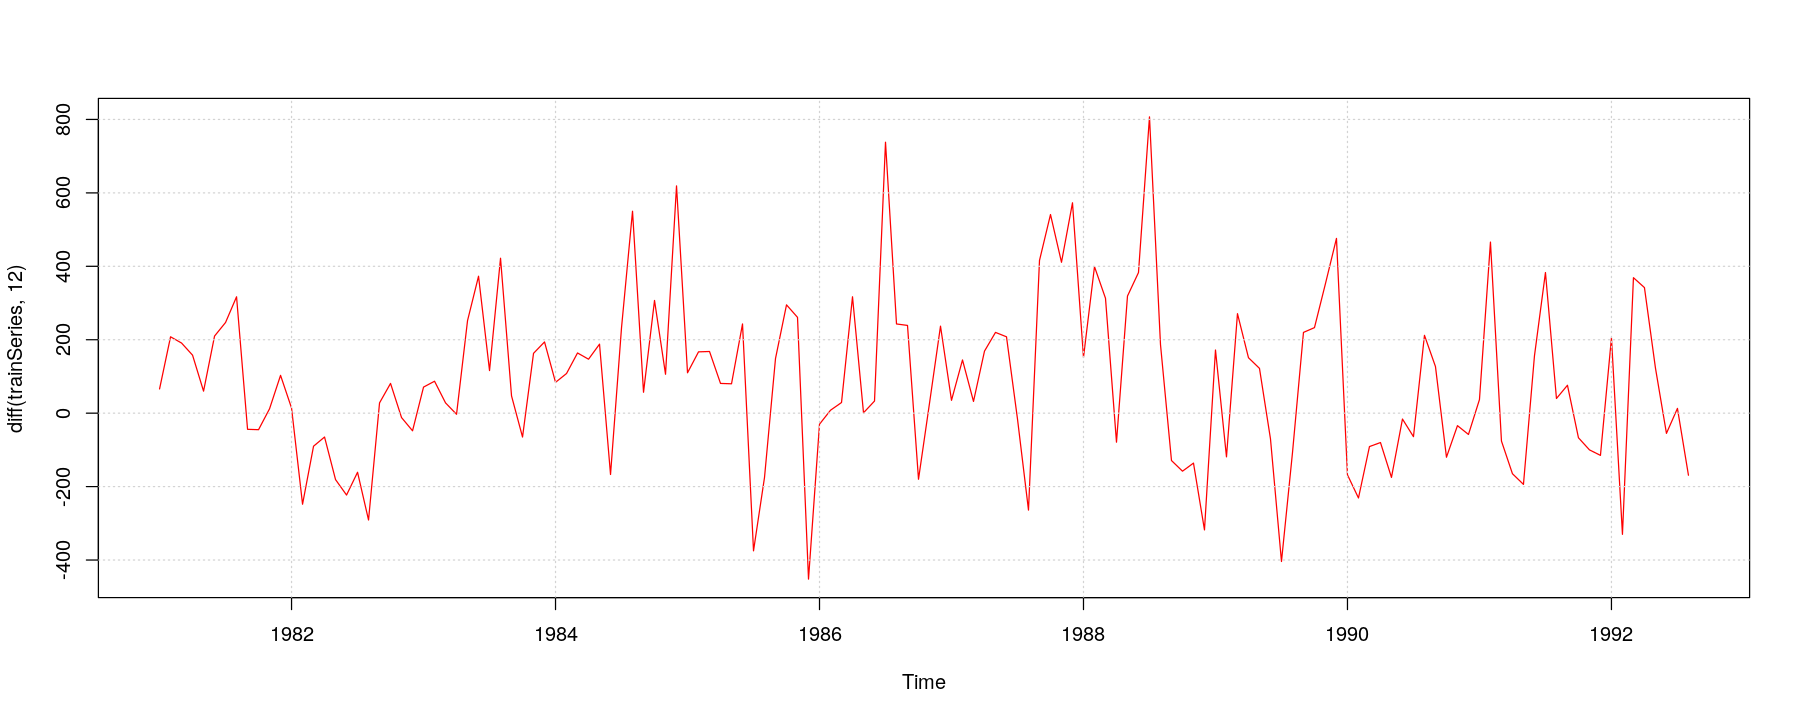

In [21]:
plot(diff(trainSeries, 12), type = "l", col = "red")
grid()

Снова применим критерий KPSS

In [22]:
round(kpss.test(diff(trainSeries, 12))$p.value, 4)

Warning message in kpss.test(diff(trainSeries, 12)):
“p-value greater than printed p-value”


[1] 0.1

Для полученного ряда гипотеза стационарности не отвергается.

Посмотрим на ACF и PACF полученного продифференцированного ряда:

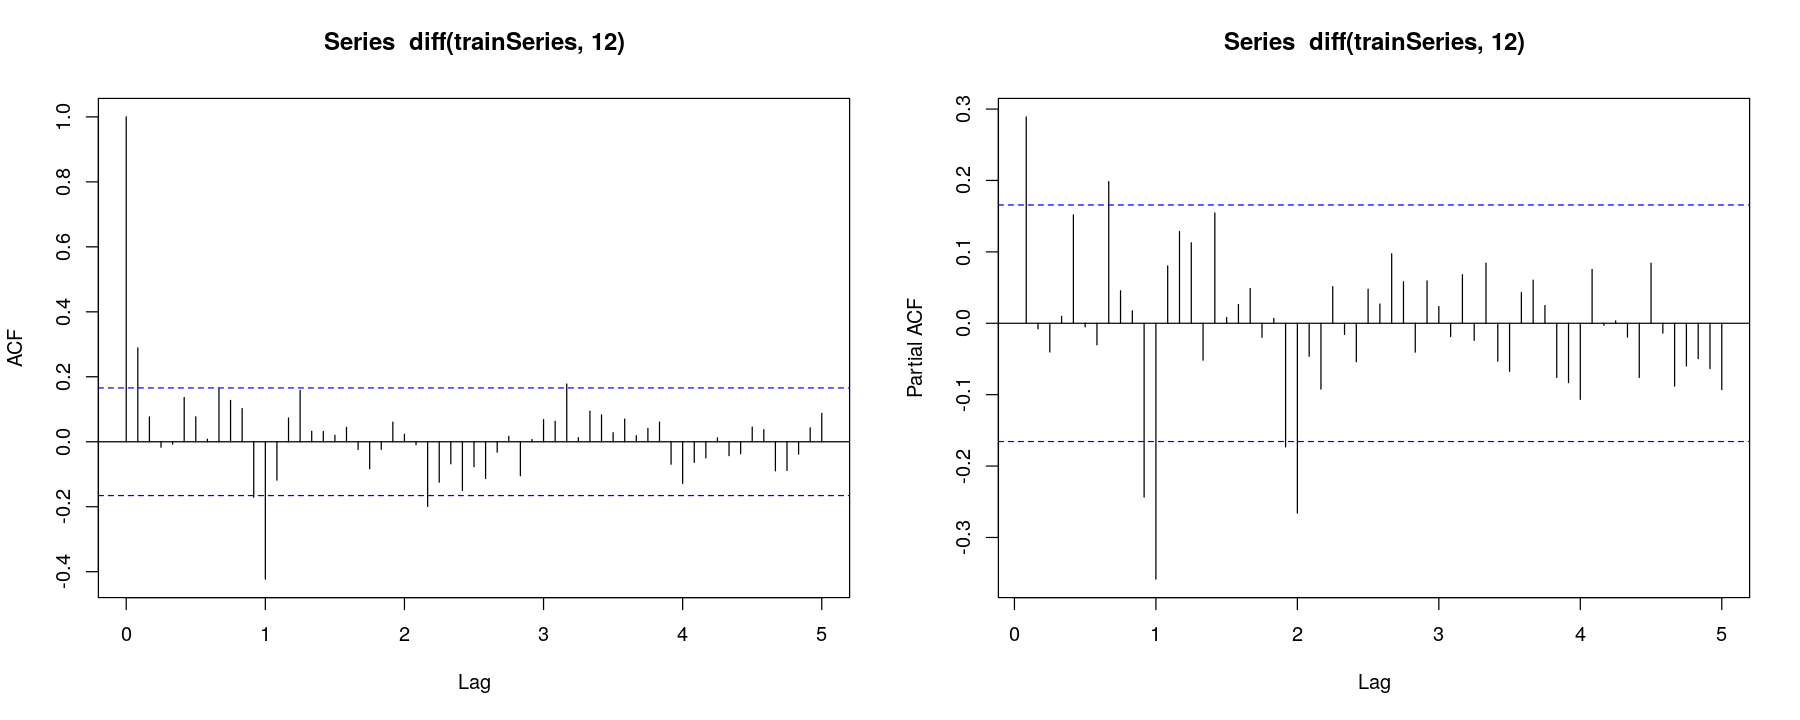

In [23]:
par(mfrow = c(1,2))
acf(diff(trainSeries, 12), lag.max = 5*12)
pacf(diff(trainSeries, 12), lag.max = 5*12)

На ACF значимы лаги 1 и 12, на PACF — 1 и близкие к сезонным. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(1,0,1)(0,1,1)$_{12}$.

Разберемся для начала с функцией обучения модели

Аргументы:
* `x` --- одномерный временный ряд;
* `order` --- гиперпараметры $(p, d, q)$;
* `seasonal` --- гиперпараметры $(P, D, Q)$, либо лист из двух элементов --- `order`=$(P, D, Q)$ и `period`=$s$;
* `xreg` --- вектор или матрица экзогенных признаков. Число строк матрицы равно длине временного ряда;
* `include.mean` --- Включать ли свободный параметр в модель;
* `transform.pars` --- Преобразовывать ли параметры AR-компоненты так, чтобы модель оставалась стационарной;
* `init` --- инициализация параметров;
* `method` --- метод обучения: максимизация правдоподобия или минимизация условной суммы квадратов. По умолчанию (если нет пропусков), сначала применяется минимизация условной суммы квадратов, затем -- максимизация правдоподобия.

Перебираем различные значения гиперпараметров и смотрим качество по AIC

In [24]:
for (p in 1:3) {
    for (q in 1:3) {
        for (P in 0:1) {
            for (Q in 0:1) {
                print(c(p, q, P, Q, arima(trainSeries, 
                                          order = c(p, 1, q), 
                                          seasonal = c(P, 1, Q))$aic))
            }
        }
    }
}

[1]    1.00    1.00    0.00    0.00 1898.15
[1]    1.000    1.000    0.000    1.000 1860.174
[1]    1.000    1.000    1.000    0.000 1868.088
[1]    1.000    1.000    1.000    1.000 1861.058
[1]    1.00    2.00    0.00    0.00 1900.15
[1]    1.000    2.000    0.000    1.000 1862.173
[1]    1.000    2.000    1.000    0.000 1869.992
[1]    1.000    2.000    1.000    1.000 1863.143
[1]    1.000    3.000    0.000    0.000 1901.948
[1]    1.00    3.00    0.00    1.00 1863.82
[1]    1.000    3.000    1.000    0.000 1871.664
[1]    1.000    3.000    1.000    1.000 1865.065
[1]    2.00    1.00    0.00    0.00 1900.15
[1]    2.000    1.000    0.000    1.000 1862.171
[1]    2.000    1.000    1.000    0.000 1869.859
[1]    2.00    1.00    1.00    1.00 1863.04
[1]    2.000    2.000    0.000    0.000 1901.767
[1]    2.000    2.000    0.000    1.000 1864.036
[1]    2.000    2.000    1.000    0.000 1871.828
[1]    2.000    2.000    1.000    1.000 1864.917
[1]    2.000    3.000    0.000    0.000 1892.

Warning message in arima(trainSeries, order = c(p, 1, q), seasonal = c(P, 1, Q)):
“possible convergence problem: optim gave code = 1”


[1]    3.000    3.000    1.000    1.000 1866.321


Наилучшая по AICc модель — ARIMA(2, 1, 3)(0, 1, 1)$_{12}$. Обучим ее и посмотрим на вывод. Для каждого коэффициента приведена оценка его значения и оценка стандартного отклонения этой оценки. Название коэффициентов состоит из его типа и номера. Например, `ar2` --- 2-й коэффициент AR-компоненты, то есть перед $y_{t-2}$, а `sma1` --- 1-й коэффициент сезонной MA-компоненты, то есть перед $\varepsilon_{t-12}$. Далее указаны также оценка $\sigma^2$. логарифм функции правдоподобия и AIC-критерия.

In [25]:
model.arima <- arima(trainSeries, order = c(2, 1, 3), seasonal = c(0, 1, 1))
model.arima


Call:
arima(x = trainSeries, order = c(2, 1, 3), seasonal = c(0, 1, 1))

Coefficients:
         ar1      ar2      ma1     ma2      ma3     sma1
      0.3770  -0.9686  -1.1772  1.2770  -0.8520  -0.5681
s.e.  0.0361   0.0365   0.0629  0.0634   0.0616   0.0796

sigma^2 estimated as 31924:  log likelihood = -922.92,  aic = 1859.85

Посмотрим на её остатки:

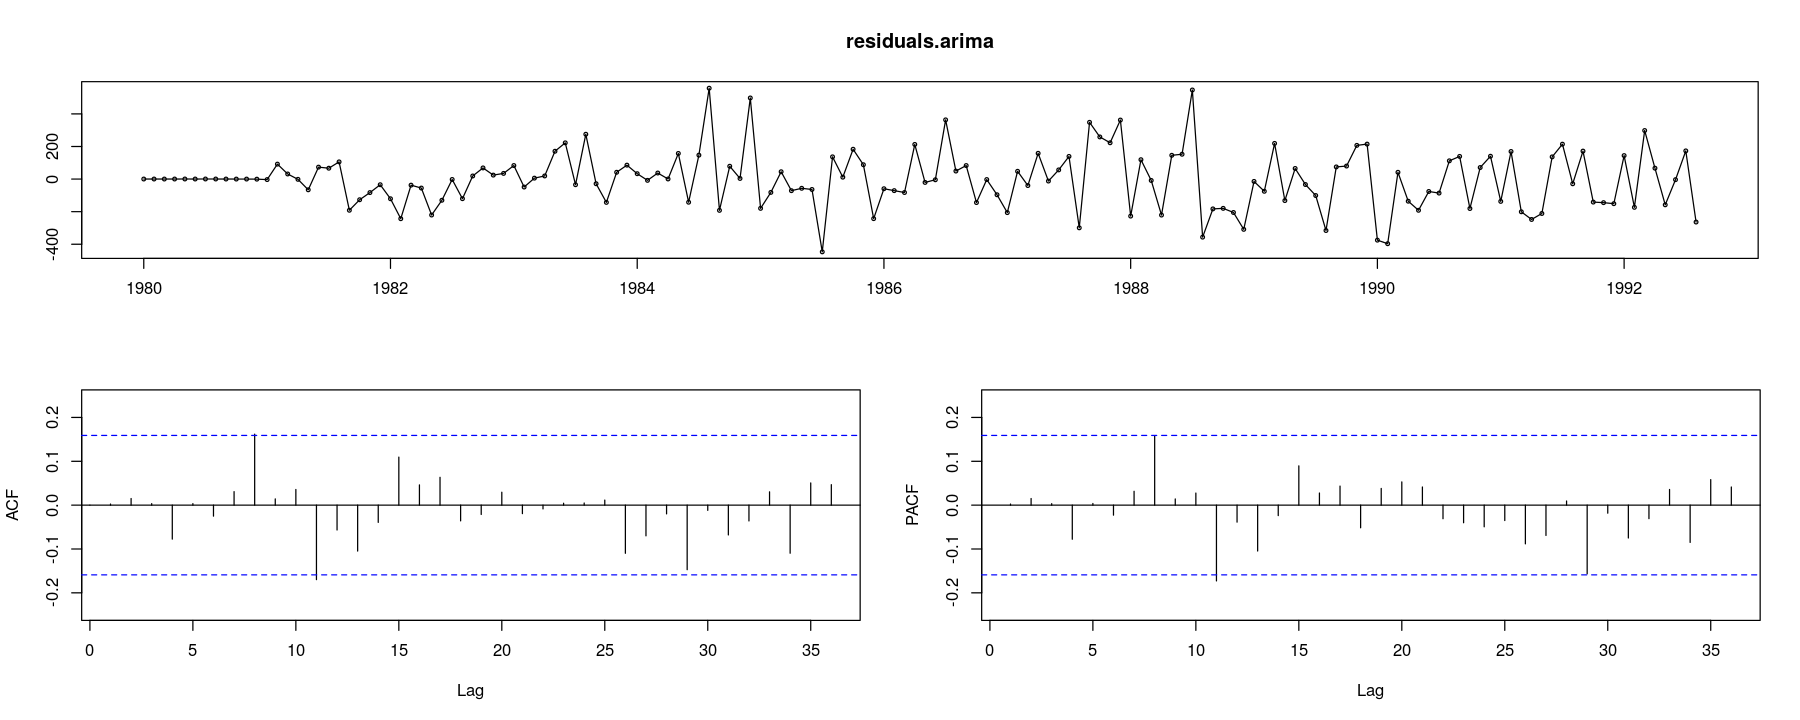

In [26]:
residuals.arima <- residuals(model.arima)

tsdisplay(residuals.arima)

p-value критерия Льюнга-Бокса о наличии значимых лагов автокорреляции. Видим, что все p-value больше порога, поэтому значимых автокорреляций нет

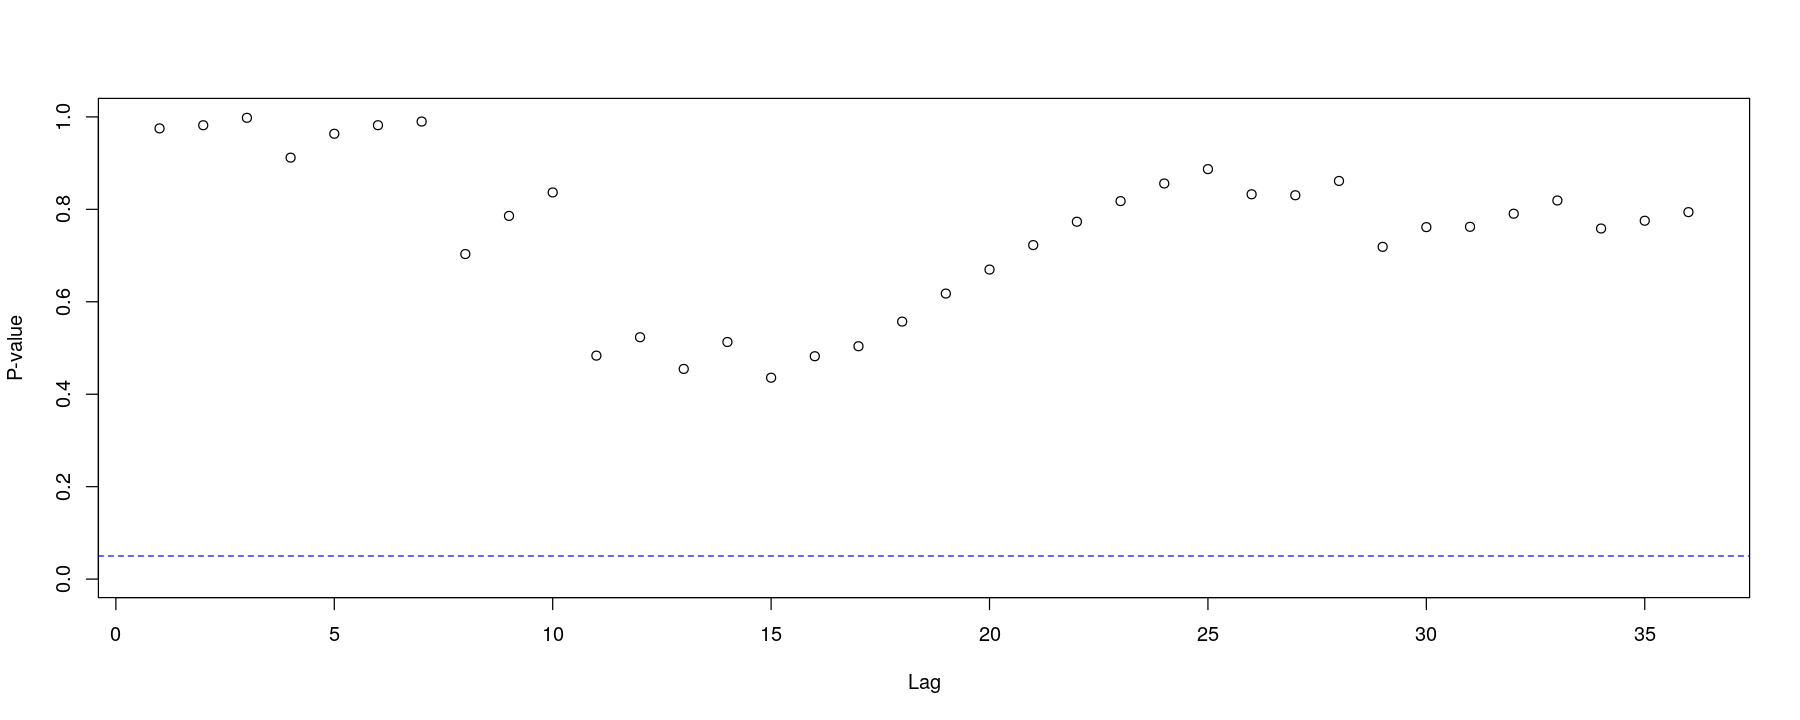

In [27]:
p <- rep(0, 1, frequency(residuals.arima)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(residuals.arima, lag = i, type = "Ljung-Box")$p.value
}

plot(p, xlab = "Lag", ylab = "P-value", ylim = c(0, 1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot и гистограмма для остатков:

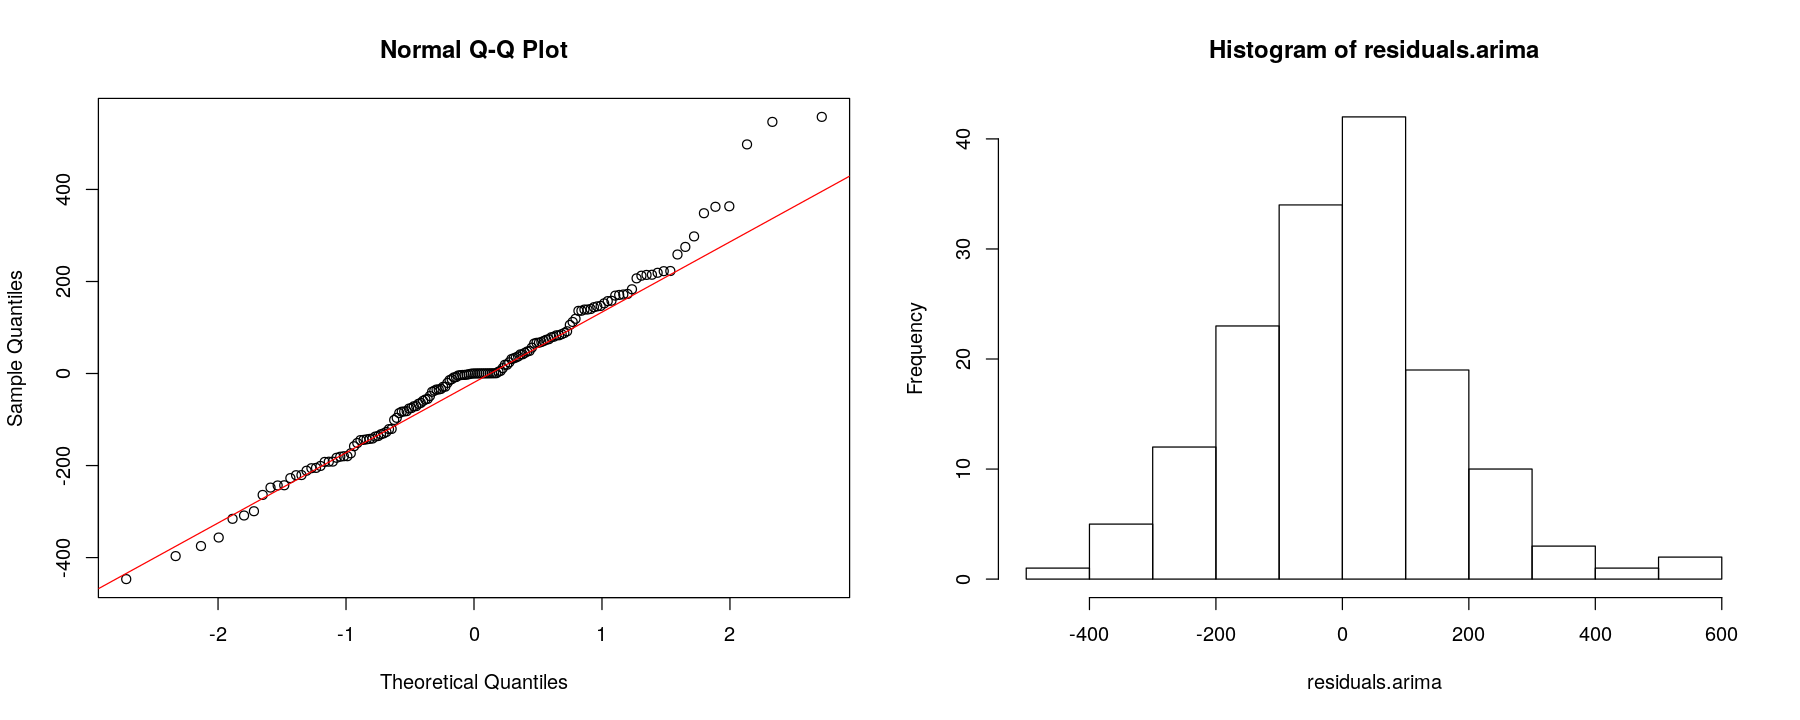

In [28]:
# два графика в строчку
par(mfrow = c(1, 2))
# QQ-plot и линия на нем
qqnorm(residuals.arima)
qqline(residuals.arima, col = "red")
# гистограмма
hist(residuals.arima)

На распределении остатков видны выбросы; скорее всего, из-за них гипотеза нормальности будет отклонена. 

In [29]:
shapiro.test(residuals.arima)$p.value
wilcox.test(residuals.arima)$p.value
kpss.test(residuals.arima)$p.value
bptest(residuals.arima ~ c(1:length(residuals.arima)))$p.value

[1] 0.02313097

[1] 0.6370559

Warning message in kpss.test(residuals.arima):
“p-value greater than printed p-value”


[1] 0.1

BP 
0.01414736

* Нормальность --- отвергается
* Несмещённость --- не отвергается
* Стационарность --- не отвергается
* Гомоскедастичность --- отвергается 

Из-за отсутствия нормальности в итоговом прогнозе будем использовать предсказательные интервалы, полученные с помощью симуляции.

Посчитаем качество на тестовом отрезке ряда

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-3.146065,170.8630,126.8490,-1.466598,8.382784,0.6763217,0.002503462,NA
Test set,267.998638,442.6141,357.2518,7.946218,14.952211,1.9047623,0.190174226,0.583871


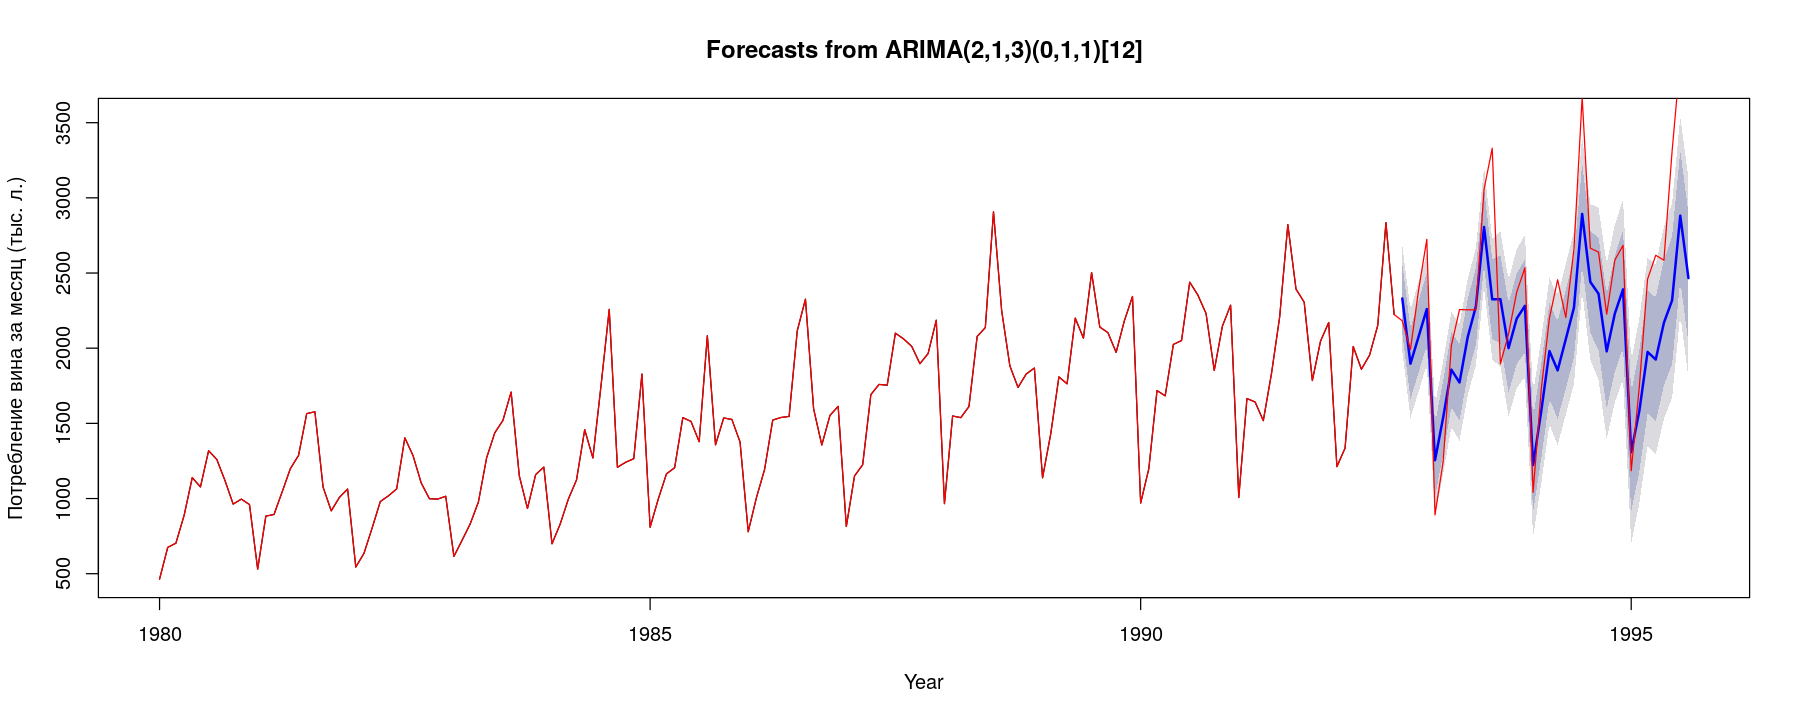

In [30]:
# Предсказания
predicted <- forecast(model.arima, h=D)

# Качество предсказания
accuracy(predicted, testSeries)

# График
plot(predicted, ylab = xname, xlab = "Year")
lines(tSeries, col = "red")

Можно посмотреть на сами прогнозы и границы предсказательных интервалов

In [31]:
head(data.frame(predicted))

,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sep 1992,2330.597,2100.315,2560.879,1978.4114,2682.783
Oct 1992,1897.012,1662.107,2131.918,1537.7551,2256.270
Nov 1992,2077.836,1838.624,2317.047,1711.9928,2443.678
Dec 1992,2260.310,2019.381,2501.239,1891.8405,2628.779
Jan 1993,1254.702,1012.597,1496.807,884.4346,1624.970
Feb 1993,1538.825,1293.792,1783.859,1164.0790,1913.571


## 5. ARIMA, автоматический подбор модели с помощью `auto.arima`


* `x` --- одномерный временный ряд;
* `d` --- количество дифференцирований ряда, по умолчанию подбирается автоматически на основе `test`;
* `D` --- количество сезонных дифференцирований ряда, по умолчанию подбирается автоматически на основе `season.test`;
* `max.p`, `max.d`, `max.q`, `max.P`, `max.D`, `max.Q` --- максимальные значения гиперпараметров, которые будут попробованны;
* `max.order` --- максимальное значение $p+q+P+Q$ если выбор модели не пошаговый;
* `stationary` --- если `TRUE`, то поиск ограничивается стационарными моделями;
* `seasonal` --- если `FALSE`, то поиск ограничивается несезонными моделями;
* `ic` --- Информационный критерий, используемый для выбора модели;
* `stepwise` --- Использовать ли пошаговый выбор модели (работает быстрее). Если нет, то выполняется поиск по всем моделям. Это может быть очень медленно, особенно для сезонных моделей;
* `nmodels` --- максимальное количество моделей в пошаговом поиске;
* `trace` --- печатать ли информацию о рассмотренных моделях;
* `approximation` --- если `TRUE`, то оценка производится с помощью условных сумм квадратов, а информационные критерии, используемые для выбора модели, аппроксимируются. Окончательная модель вычисляется с использованием оценки максимального правдоподобия. Аппроксимация может быть использована для длинных временных рядов или высокого сезонного периода, воизбежании долгих вычислений;
* `method` --- метод обучения: максимизация правдоподобия или минимизация условной суммы квадратов. По умолчанию (если нет пропусков), сначала применяется минимизация условной суммы квадратов, затем -- максимизация правдоподобия;
* `truncate` --- Количество наблюдений, которое следует использовать при выборе модели;
* `xreg` --- вектор или матрица экзогенных признаков. Число строк матрицы равно длине временного ряда;
* `test` --- Тип критерия единичного корня (проверка на стационарность). По умолчанию используется KPSS;
* `test.args` --- Его аргументы;
* `seasonal.test` --- Определяет, какой метод используется для выбора количества сезонных дифференцирований. По умолчанию метод заключается в использовании STL-декомпозиции. Другие критерии включают сезонные тесты на основе единичных корней;
* `seasonal.test.args` --- Его аргументы;
* `allowdrift` --- рассматривать ли модели с дрифтом, то есть включать ли компоненту, непосредственно зависящую от времени;
* `allowmean` --- рассматривать ли модели с ненулевым смещением;
* `lambda` --- параметр преобразования Бокса-Кокса. По умолчанию игнорируется. Если указано `"auto"`, то выбирается автоматически с помощью `BoxCox.lambda`;
* `parallel` --- использовать ли параллельный выбор модели. Не работает если `stepwise = TRUE`;
* `num.cores` --- количество параллельных процессов.

Попробуем обучить с параметрами по умолчанию. Вывод модели аналогичен модели, подобранной вручную

In [32]:
model.auto <- auto.arima(trainSeries)
model.auto

Series: trainSeries 
ARIMA(1,0,1)(0,1,1)[12] with drift 

Coefficients:
         ar1      ma1     sma1   drift
      0.9355  -0.7969  -0.6142  7.5293
s.e.  0.0568   0.0898   0.0751  1.7312

sigma^2 estimated as 34208:  log likelihood=-930.17
AIC=1870.35   AICc=1870.79   BIC=1885.05

Предлагается модель ARIMA(1,1,2)(0,1,1)$_{12}$ с дрифтом, т.е. с дополнительным слагаемым $7.5293\cdot t$. Её `AIC` выше, чем у модели, подобранной вручную.

Посмотрим на её остатки:

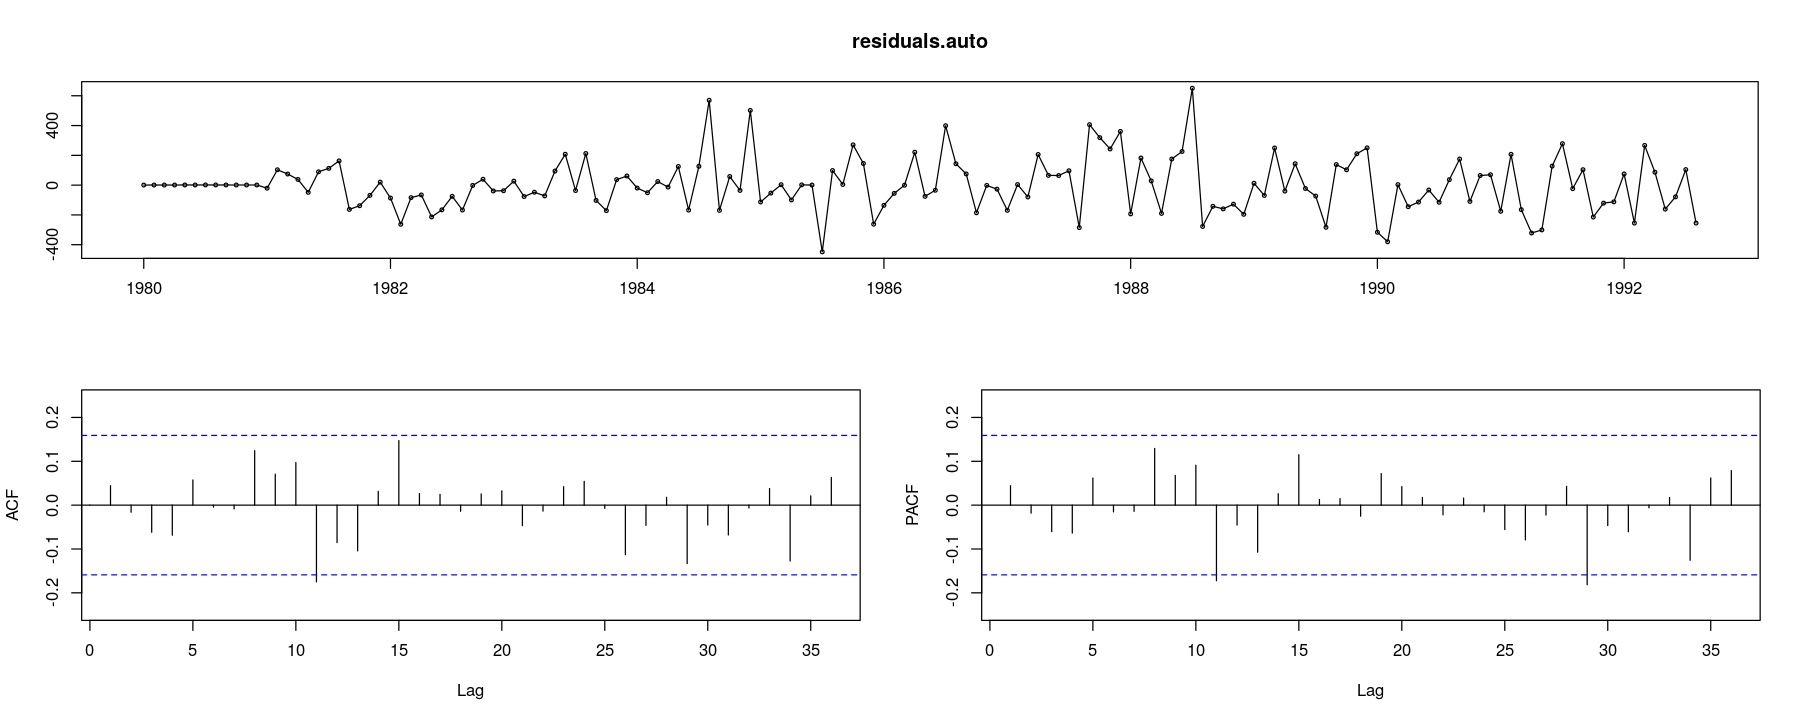

In [33]:
residuals.auto <- residuals(model.auto)

tsdisplay(residuals.auto)

p-value критерия Льюнга-Бокса о наличии значимых лагов автокорреляции. Опять же, значимых автокорреляций нет

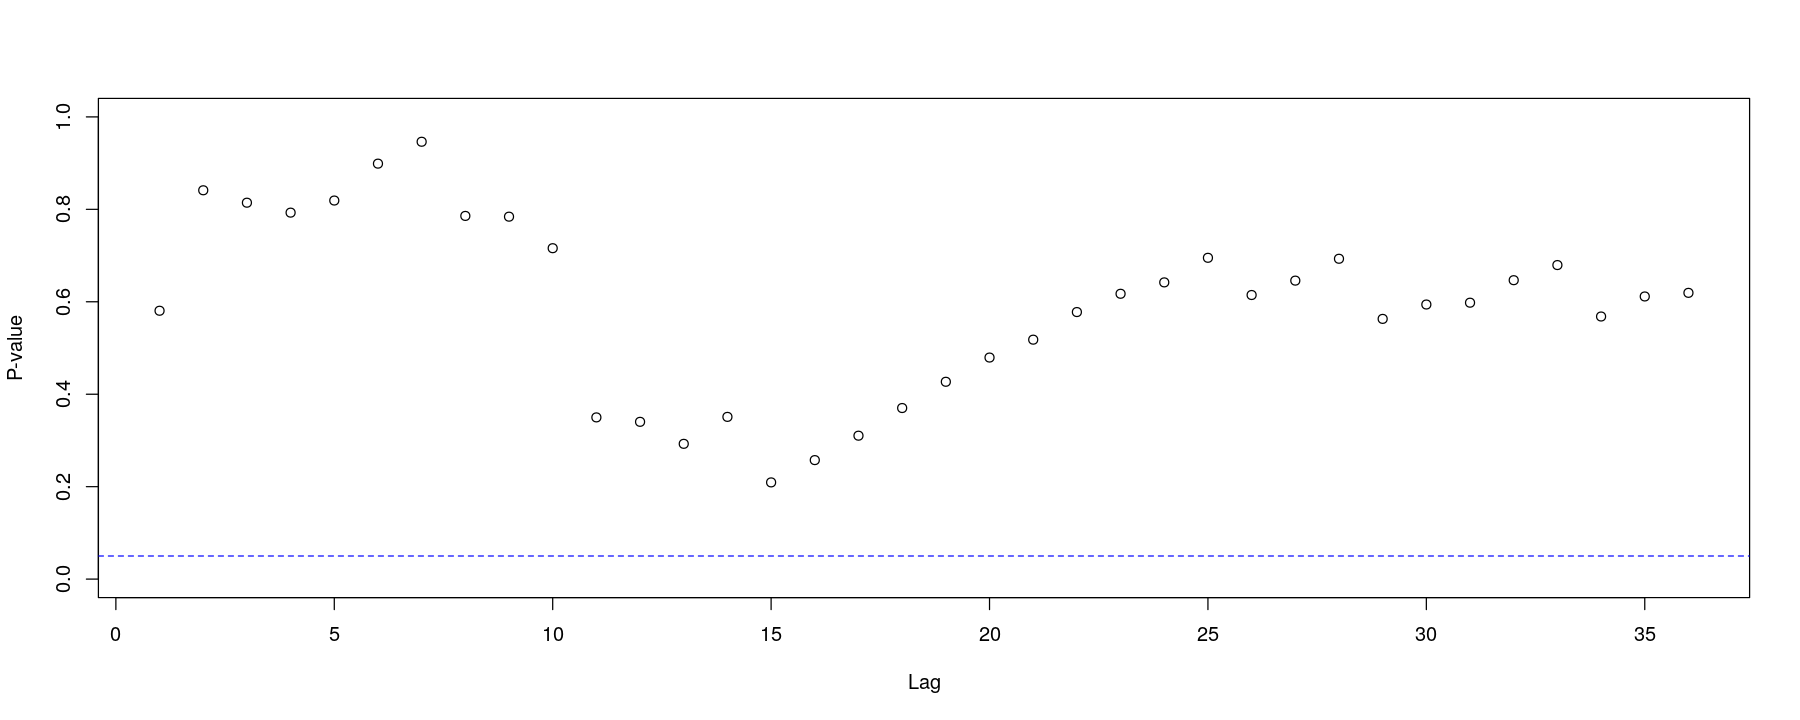

In [34]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(residuals.auto, lag = i, type = "Ljung-Box")$p.value
}

plot(p, xlab = "Lag", ylab = "P-value", ylim = c(0, 1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot и гистограмма для остатков:

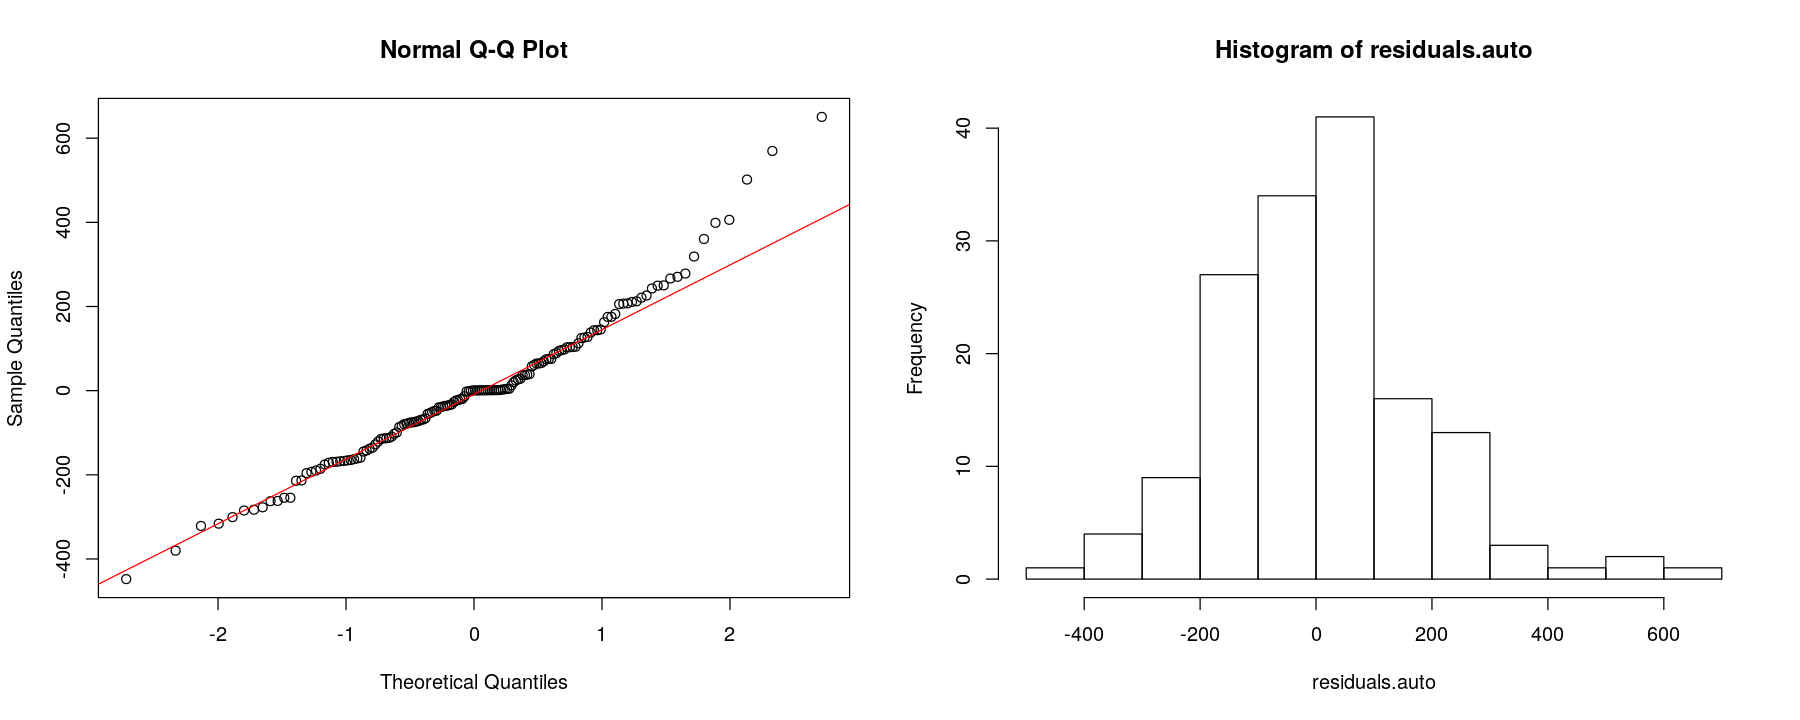

In [35]:
par(mfrow = c(1, 2))
qqnorm(residuals.auto)
qqline(residuals.auto, col = "red")
hist(residuals.auto)

In [36]:
shapiro.test(residuals.auto)$p.value
wilcox.test(residuals.auto)$p.value
kpss.test(residuals.auto)$p.value
bptest(residuals.auto ~ c(1:length(residuals.auto)))$p.value

[1] 0.002716171

[1] 0.5994697

Warning message in kpss.test(residuals.auto):
“p-value greater than printed p-value”


[1] 0.1

BP 
0.0237753

* Нормальность --- отвергается
* Несмещённость --- не отвергается
* Стационарность --- не отвергается
* Гомоскедастичность --- отвергается 

Посчитаем качество на тестовой выборке

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.005073743,174.9503,128.8351,-1.557364,8.522846,0.6869111,0.04437596,NA
Test set,171.749062200,368.2348,278.3693,3.687218,12.166080,1.4841839,0.14479630,0.4827358


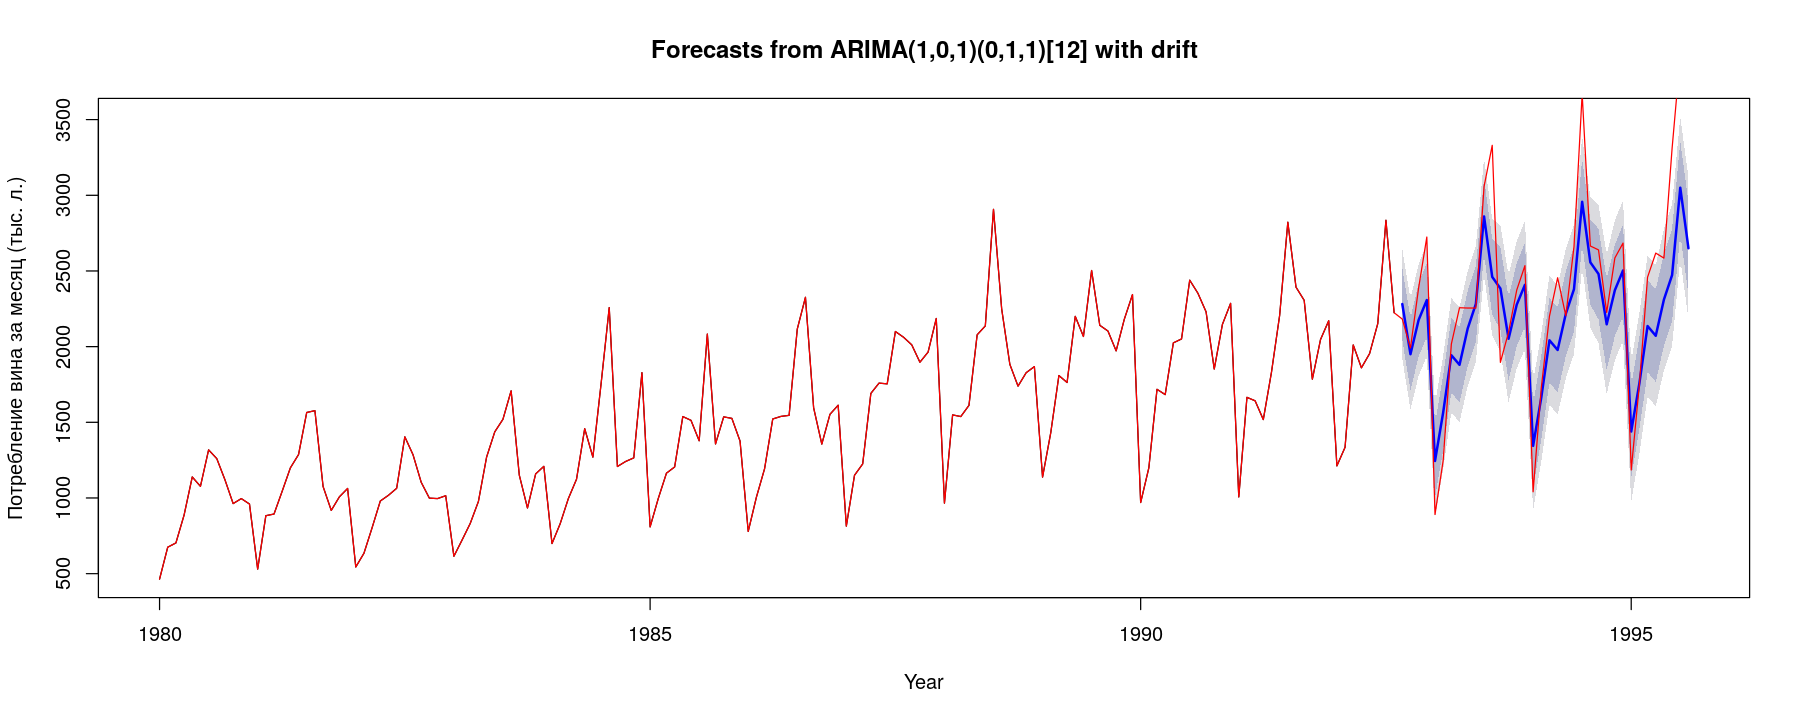

In [37]:
# Предсказания
predicted <- forecast(model.auto, h = D)

# Качество предсказания
accuracy(predicted, testSeries)

# График
plot(predicted, ylab = xname, xlab = "Year")
lines(tSeries, col = "red")

Вспомним, какие значения метрик мы получили на тестовой части ряда для модели, подобранной вручную

In [38]:
accuracy(forecast(model.arima, h=D), testSeries)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-3.146065,170.8630,126.8490,-1.466598,8.382784,0.6763217,0.002503462,NA
Test set,267.998638,442.6141,357.2518,7.946218,14.952211,1.9047623,0.190174226,0.583871


Как видим, по всем метрикам ошибка на тестовой выборке у автоматической модели меньше, чем у модели, подобранной вручную. Это не всегда так на практике; возможно, стоило провести более тщательный анализ.

Как и ранее, можно извлечь на сами прогнозы и границы предсказательных интервалов

In [39]:
head(data.frame(predicted))

,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sep 1992,2281.341,2044.311,2518.371,1918.8343,2643.848
Oct 1992,1950.024,1710.727,2189.320,1584.0513,2315.996
Nov 1992,2176.587,1935.324,2417.849,1807.6077,2545.565
Dec 1992,2307.854,2064.884,2550.824,1936.2640,2679.444
Jan 1993,1244.648,1000.194,1489.102,870.7881,1618.508
Feb 1993,1564.627,1318.882,1810.373,1188.7917,1940.462


Для первичного сравнения моделей полезно также сравнивать их остатки на обучающей выборке. Нарисуем график зависимости остатков одной модели от остатков другой. Также можно использовать критерий Дибольда-Марьяно для гипотезы о том, что две модели прогнозирования имеют одинаковую точность прогноза. Функция также принимает параметры `h` --- горизонт прогнозирования и `power` --- степень (1 или 2) лосс-функции.


	Diebold-Mariano Test

data:  residuals.arimaresiduals.auto
DM = -0.97674, Forecast horizon = 1, Loss function power = 2, p-value =
0.3303
alternative hypothesis: two.sided


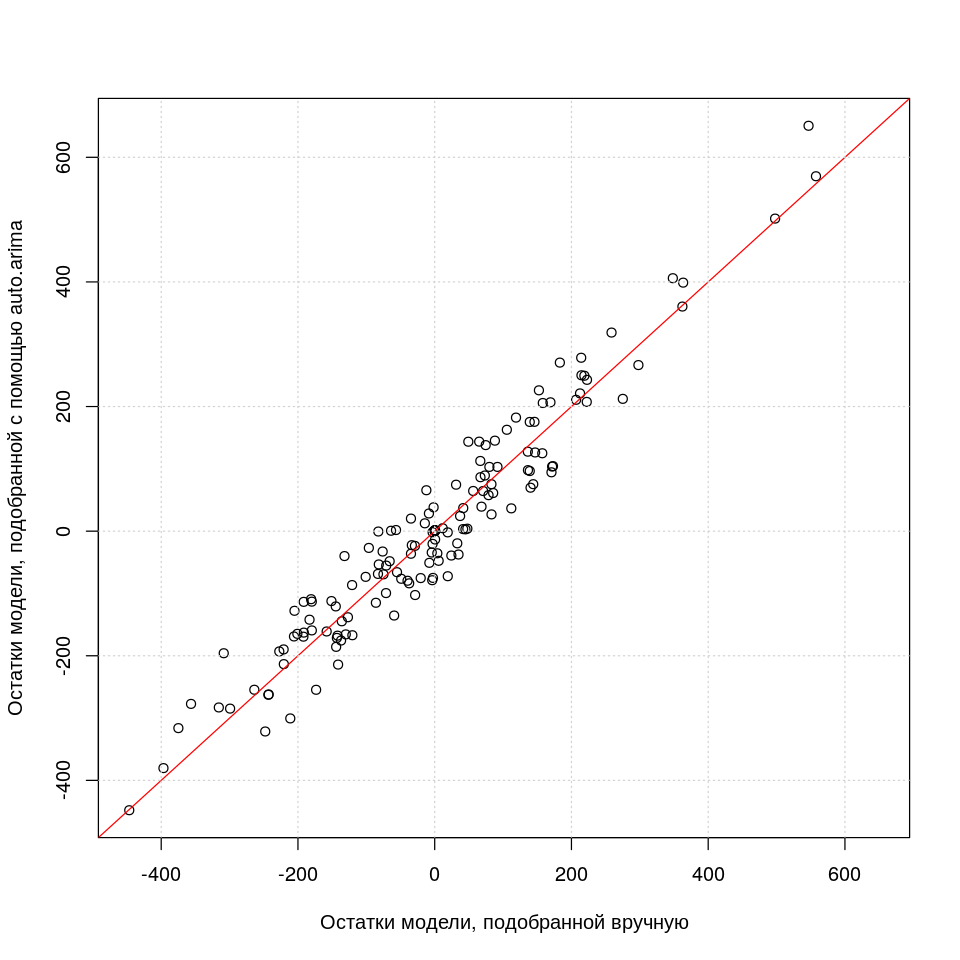

In [40]:
# Границы графика
min.value = min(residuals.arima, residuals.auto)
max.value = max(residuals.arima, residuals.auto)
limits = c(min.value, max.value)

# Размеры графика
options(repr.plot.width = 8, repr.plot.height = 8)

# График остатки-остатки
plot(residuals.arima, residuals.auto, 
     xlim = limits, ylim = limits, 
     xlab = "Остатки модели, подобранной вручную", 
     ylab = "Остатки модели, подобранной с помощью auto.arima")
lines(limits*2, limits*2, col="red")
grid()

# проверка гипотезы
dm.test(residuals.arima, residuals.auto)

Критерий не отвергает гипотезу об одинаковом качестве моделей. По значению AIC модель, подобранная вручную оказалась лучше. Однако на тестовой выборке автоматическая модель показывает меньшую ошибку. 

## 6. Итоговое сравнение и прогноз на будущее

Сравним остатки моделей ARIMA и ETS. Гипотезы об одинаковом качестве отвергаются.

In [41]:
# проверка гипотезы
dm.test(residuals.ets, residuals.auto)
dm.test(residuals.ets, residuals.arima)


	Diebold-Mariano Test

data:  residuals.etsresiduals.auto
DM = -6.6727, Forecast horizon = 1, Loss function power = 2, p-value =
4.476e-10
alternative hypothesis: two.sided



	Diebold-Mariano Test

data:  residuals.etsresiduals.arima
DM = -7.1374, Forecast horizon = 1, Loss function power = 2, p-value =
3.723e-11
alternative hypothesis: two.sided


Сравним также их предсказания на тестовом множестве

In [42]:
print("ets")
accuracy(forecast(model.ets, h = D), testSeries)

print("arima")
accuracy(forecast(model.arima, h = D), testSeries)

print("auto.arima")
accuracy(forecast(model.auto, h = D), testSeries)

[1] "ets"


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,27.4637,176.9042,128.9961,0.845731,8.30697,0.6877698,-0.006536106,NA
Test set,426.9203,549.8809,455.5682,15.680692,18.15986,2.4289570,0.209402942,0.7716804


[1] "arima"


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-3.146065,170.8630,126.8490,-1.466598,8.382784,0.6763217,0.002503462,NA
Test set,267.998638,442.6141,357.2518,7.946218,14.952211,1.9047623,0.190174226,0.583871


[1] "auto.arima"


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.005073743,174.9503,128.8351,-1.557364,8.522846,0.6869111,0.04437596,NA
Test set,171.749062200,368.2348,278.3693,3.687218,12.166080,1.4841839,0.14479630,0.4827358


Наилучшее качество на тестовой выборке показала автоматическая модель. Построим итоговый прогноз с ее использованием на 3 года вперед.

In [ ]:
f <- forecast(model.auto, h = D, bootstrap = TRUE)
print(f)

options(repr.plot.width = 15, repr.plot.height = 6)
plot(f, ylab = xname, xlab = "Year", col = "red")

         Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
Sep 1992       2281.341 2088.295 2493.684 1980.7622 2680.211
Oct 1992       1950.024 1746.832 2168.247 1633.9876 2350.346
Nov 1992       2176.587 1968.715 2401.061 1860.1487 2625.781
Dec 1992       2307.854 2087.318 2527.908 1986.6702 2722.572
Jan 1993       1244.648 1024.677 1470.771  917.8271 1657.445
Feb 1993       1564.627 1345.991 1790.943 1240.4902 1987.845
Mar 1993       1943.323 1733.608 2178.024 1622.3411 2419.548
Apr 1993       1879.802 1664.725 2109.015 1551.3696 2306.377
May 1993       2119.612 1894.849 2341.686 1784.9809 2535.479
Jun 1993       2282.315 2059.190 2509.562 1948.8505 2707.895
Jul 1993       2860.107 2631.899 3078.679 2522.0906 3279.132
Aug 1993       2460.719 2233.850 2678.600 2128.5829 2849.438
Sep 1993       2384.042 2143.405 2631.165 2016.9773 2821.547
Oct 1993       2051.928 1808.047 2301.347 1681.4373 2493.340
Nov 1993       2277.746 2026.391 2535.358 1912.1580 2739.363
Dec 1993       2408.316 